In [ ]:
!pip install scikit-dimension
!pip install jsonlines

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 1.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/VZ_DS/PHD/TopAnDat/four_week')

In [ ]:
import skdim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import torch
import nltk
from plotly.subplots import make_subplots
from phd import get_phd, get_raw_phd, get_embeds, get_raw_phd_in_loop
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import modeling_utils
if not hasattr(modeling_utils, "ALL_PARALLEL_STYLES") or modeling_utils.ALL_PARALLEL_STYLES is None:
    modeling_utils.ALL_PARALLEL_STYLES = ["tp", "none", "colwise", 'rowwise']

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
import jsonlines
import pandas as pd

file_path = '/content/drive/MyDrive/Colab Notebooks/VZ_DS/PHD/TopAnDat/data/en_train.jsonl'

data = []
with jsonlines.open(file_path, 'r') as reader:
    for obj in reader:
        data.append(obj)

df = pd.DataFrame(data)
df.head()

,id,source,sub_source,lang,model,label,text
0,f05034ca-d1da-445d-a6a2-5869ade0dfc3,m4gt,reddit,en,llama3-8b,1,Hitler's plans for the succession and power st...
1,e7d7fe23-3709-4e14-aa2d-d76821dcbdf6,mage,squad,en,human,0,The Bush administration then turned its attent...
2,1a68d42e-4202-4e36-bceb-02d693440a14,mage,yelp,en,human,0,Really really the best pedi ever! Pho was so a...
3,5de844ab-c197-4378-b144-c3a46e3f5b67,mage,xsum,en,human,0,The PS42m MV Loch Seaforth made its first pass...
4,cdf050ad-7d90-4235-b7c6-46ca6cfc4382,m4gt,wikipedia,en,human,0,Malta participated in the Eurovision Song Cont...


## Разные способы усреднения

In [ ]:
def get_embeds_and_tokens(df):
    embeds_list = []
    tokens_list = []
    embeds_list_text = []
    tokens_list_text = []
    for i in tqdm(range(2, 50, 2)):
        text = ''.join(df['text'].values.tolist()[i:(i + 1)])
        embeds, tokens = get_embeds(text[:2000], returns_tokenized=True)
        embeds_list.extend(embeds)
        tokens_list.extend(tokens)
        embeds_list_text.append(embeds)
        tokens_list_text.append(tokens)

    return embeds_list, tokens_list, embeds_list_text, tokens_list_text

In [ ]:
MIN_TOKENS = 47

### Глобальное усреднение

In [ ]:
def compute_phd_by_pos_global(tokens, embeds, pos_tags=['NOUN', '.', 'VERB', 'ADJ']):
    """
    Считает PHD отдельно по каждому POS в глобальном (pooled) стиле.

    tokens: List[str]
    embeds: List[np.ndarray]
    pos_tags: список интересующих POS-тегов

    Возвращает:
    - словарь {pos_tag: phd_value}
    """
    tagged = nltk.pos_tag(tokens, tagset='universal')
    df = pd.DataFrame(tagged, columns=['token', 'pos'])
    df['embed'] = list(embeds)

    pos2phd = {}

    for pos in tqdm(pos_tags):
        df_sub = df[df['pos'] == pos]
        if len(df_sub) < MIN_TOKENS:
            continue
        embeds_sub = np.array(df_sub['embed'].tolist())

        normed = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
        phd = np.mean(get_raw_phd_in_loop(normed, n_tries=5))
        pos2phd[pos] = phd

    return pos2phd


def compute_phd_without_pos_global(tokens, embeds, pos_tags=['NOUN', '.', 'VERB', 'ADJ']):
    """
    Считает PHD по всем токенам, КРОМЕ заданной части речи (поочерёдно).

    tokens: List[str] — объединённые токены из всех текстов
    embeds: List[np.ndarray] — соответствующие эмбеддинги
    pos_tags: список POS, которые будем исключать по очереди

    Возвращает:
    - словарь {pos_tag: phd_value} — PHD без этой POS
    """

    tagged = nltk.pos_tag(tokens, tagset='universal')
    df = pd.DataFrame(tagged, columns=['token', 'pos'])
    df['embed'] = list(embeds)

    pos2phd = {}

    for pos in tqdm(pos_tags):
        df_sub = df[df['pos'] != pos]
        if len(df_sub) < MIN_TOKENS:
            continue
        embeds_sub = np.array(df_sub['embed'].tolist())
        normed = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
        phd = np.mean(get_raw_phd_in_loop(normed, n_tries=5))
        pos2phd[pos] = phd

    return pos2phd

### Усреднение по PHD для каждого текста

In [ ]:
def compute_phd_by_pos_per_text(tokens_list, embeds_list, pos_tags=['NOUN', '.', 'VERB', 'ADJ']):
    """
    Считает PHD отдельно по каждой POS в каждом тексте,
    потом усредняет по всем текстам.

    Возвращает:
    - словарь {pos_tag: [list of phd values]} — для boxplot
    - словарь {pos_tag: float} — среднее значение по всем текстам
    """
    pos2phd_all = {pos: [] for pos in pos_tags}

    for tokens, embeds in tqdm(zip(tokens_list, embeds_list)):
        tagged = nltk.pos_tag(tokens, tagset='universal')
        df = pd.DataFrame(tagged, columns=['token', 'pos'])
        df['embed'] = list(embeds)

        for pos in pos_tags:
          df_sub = df[df['pos'] == pos]
          if len(df_sub) < MIN_TOKENS:
              continue
          embeds_sub = np.array(df_sub['embed'].tolist())
          norm = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
          phd = np.mean(get_raw_phd_in_loop(norm, n_tries=5))
          pos2phd_all[pos].append(phd)

    pos2phd_mean = {pos: np.mean(vals) for pos, vals in pos2phd_all.items() if len(vals) > 0}
    return pos2phd_all, pos2phd_mean


def compute_phd_without_pos_per_text(tokens_list, embeds_list, pos_tags=['NOUN', '.', 'VERB', 'ADJ']):
    """
    Для каждого текста считает PHD без каждого POS (по очереди),
    затем агрегирует по всем текстам.

    Аргументы:
    - tokens_list: List[List[token]]
    - embeds_list: List[List[embedding]]
    - pos_tags: список POS, которые исключать

    Возвращает:
    - словарь {pos_tag: [список PHD без этого POS]}
    - словарь {pos_tag: среднее значение PHD без этого POS}
    """
    pos2phd_all = {pos: [] for pos in pos_tags}

    for tokens, embeds in tqdm(zip(tokens_list, embeds_list)):
        tagged = nltk.pos_tag(tokens, tagset='universal')
        df = pd.DataFrame(tagged, columns=['token', 'pos'])
        df['embed'] = list(embeds)

        for pos in pos_tags:
            df_sub = df[df['pos'] != pos]
            if len(df_sub) < MIN_TOKENS:
                continue
            embeds_sub = np.array(df_sub['embed'].tolist())
            norm = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
            phd = np.mean(get_raw_phd_in_loop(norm, n_tries=5))
            pos2phd_all[pos].append(phd)

    pos2phd_mean = {pos: np.mean(vals) for pos, vals in pos2phd_all.items() if len(vals) > 0}
    return pos2phd_all, pos2phd_mean


In [ ]:
def plot_phd_comparison(pos_tags, per_text_vals, global_vals, title):
    """
    pos_tags: список POS
    per_text_vals: словарь {POS: значение} — per-text
    global_vals: словарь {POS: значение} — global
    title: заголовок графика
    """
    data = {
        'Per-text mean': [per_text_vals.get(pos, None) for pos in pos_tags],
        'Global':        [global_vals.get(pos, None) for pos in pos_tags],
    }

    df = pd.DataFrame(data, index=pos_tags)
    df.plot(kind='bar', rot=0)
    plt.title(title)
    plt.ylabel('PHD')
    plt.xlabel('Part of Speech')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
pos_tags = ['NOUN', '.', 'VERB', 'ADJ']

embeds_llm, tokens_llm, embeds_llm_text, tokens_llm_text = get_embeds_and_tokens(df.query("label == 1"))
embeds_human, tokens_human, embeds_human_text, tokens_human_text = get_embeds_and_tokens(df.query("label == 0"))

100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


In [ ]:
# --- LLM ---
phd_llm_global_pos = compute_phd_by_pos_global(tokens_llm, embeds_llm, pos_tags)
_, phd_llm_pertext_mean = compute_phd_by_pos_per_text(tokens_llm_text, embeds_llm_text, pos_tags)

phd_llm_global_wo = compute_phd_without_pos_global(tokens_llm, embeds_llm, pos_tags)
_, phd_llm_pertext_wo_mean = compute_phd_without_pos_per_text(tokens_llm_text, embeds_llm_text, pos_tags)

  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  2315 point_jump =  325
input_shape: (2315, 768)
mn_points =  40 max_points =  2315 point_jump =  325
input_shape: (2315, 768)
mn_points =  40 max_points =  2315 point_jump =  325
input_shape: (2315, 768)
mn_points =  40 max_points =  2315 point_jump =  325
input_shape: (2315, 768)
mn_points =  40 max_points =  2315 point_jump =  325
input_shape: (2315, 768)


 25%|██▌       | 1/4 [03:40<11:02, 220.94s/it]

mn_points =  40 max_points =  398 point_jump =  51
input_shape: (398, 768)
mn_points =  40 max_points =  398 point_jump =  51
input_shape: (398, 768)
mn_points =  40 max_points =  398 point_jump =  51
input_shape: (398, 768)
mn_points =  40 max_points =  398 point_jump =  51
input_shape: (398, 768)
mn_points =  40 max_points =  398 point_jump =  51
input_shape: (398, 768)


 50%|█████     | 2/4 [03:53<03:17, 98.59s/it] 

mn_points =  40 max_points =  614 point_jump =  82
input_shape: (614, 768)
mn_points =  40 max_points =  614 point_jump =  82
input_shape: (614, 768)
mn_points =  40 max_points =  614 point_jump =  82
input_shape: (614, 768)
mn_points =  40 max_points =  614 point_jump =  82
input_shape: (614, 768)
mn_points =  40 max_points =  614 point_jump =  82
input_shape: (614, 768)


 75%|███████▌  | 3/4 [04:10<01:01, 61.01s/it]

mn_points =  40 max_points =  571 point_jump =  75
input_shape: (571, 768)
mn_points =  40 max_points =  571 point_jump =  75
input_shape: (571, 768)
mn_points =  40 max_points =  571 point_jump =  75
input_shape: (571, 768)
mn_points =  40 max_points =  571 point_jump =  75
input_shape: (571, 768)
mn_points =  40 max_points =  571 point_jump =  75
input_shape: (571, 768)


100%|██████████| 4/4 [04:28<00:00, 67.22s/it]
0it [00:00, ?it/s]

mn_points =  40 max_points =  276 point_jump =  33
input_shape: (276, 768)
mn_points =  40 max_points =  276 point_jump =  33
input_shape: (276, 768)
mn_points =  40 max_points =  276 point_jump =  33
input_shape: (276, 768)
mn_points =  40 max_points =  276 point_jump =  33
input_shape: (276, 768)
mn_points =  40 max_points =  276 point_jump =  33
input_shape: (276, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2


1it [00:06,  6.24s/it]

mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  246 point_jump =  29
input_shape: (246, 768)
mn_points =  40 max_points =  246 point_jump =  29
input_shape: (246, 768)
mn_points =  40 max_points =  246 point_jump =  29
input_shape: (246, 768)
mn_points =  40 max_points =  246 point_jump =  29
input_shape: (246, 768)
mn_points =  40 max_points =  246 point_jump =  29
input_shape: (246, 768)
mn_points =  40 max_points =  62 point_jump =  3
input_shape: (62, 768)
mn_points =  40 max_points =  62 point_jump =  3
input_shape: (62, 768)
mn_points =  40 max_points =  62 point_jump =  3
input_shape: (62, 768)
mn_points =  40 max_points =  62 point_jump =  3
input_shape: (62, 768)
mn_points =  40 max_points =  62 point_jump =  3
input_shape: (62, 768)
mn_points =  40 max_points =  73 point_jump =  4
input_shape: (73, 768)
mn_points =  40 max_points =  73 point_jump =  4
input_shape: (73, 768)
mn_points =  40 max_points =  73 point_jump =  4


2it [00:13,  6.95s/it]

mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)


3it [00:14,  4.10s/it]

mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)


4it [00:16,  3.20s/it]

mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2


5it [00:20,  3.67s/it]

mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2


6it [00:25,  4.09s/it]

mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 768)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 768)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 768)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 768)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 768)


7it [00:26,  3.19s/it]

mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)


9it [00:27,  1.85s/it]

mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  71 point_jump =  4
input_shape: (71, 768)
mn_points =  40 max_points =  71 point_jump =  4
input_shape: (71, 768)
mn_points =  40 max_points =  71 point_jump =  4
input_shape: (71, 768)
mn_points =  40 max_points =  71 point_jump =  4
input_shape: (71, 768)
mn_points =  40 max_points =  71 point_jump =  4
input_shape: (71, 768)


10it [00:28,  1.57s/it]

mn_points =  40 max_points =  242 point_jump =  28
input_shape: (242, 768)
mn_points =  40 max_points =  242 point_jump =  28
input_shape: (242, 768)
mn_points =  40 max_points =  242 point_jump =  28
input_shape: (242, 768)
mn_points =  40 max_points =  242 point_jump =  28
input_shape: (242, 768)
mn_points =  40 max_points =  242 point_jump =  28
input_shape: (242, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 768)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 768)
mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 768)
mn_points =  40 max_points =  61 point_jump =  3


11it [00:33,  2.52s/it]

mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 768)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 768)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 768)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 768)
mn_points =  40 max_points =  59 point_jump =  2
input_shape: (59, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  57 point_jump =  2


12it [00:38,  3.19s/it]

mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 768)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 768)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 768)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 768)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)


13it [00:41,  3.24s/it]

mn_points =  40 max_points =  172 point_jump =  18
input_shape: (172, 768)
mn_points =  40 max_points =  172 point_jump =  18
input_shape: (172, 768)
mn_points =  40 max_points =  172 point_jump =  18
input_shape: (172, 768)
mn_points =  40 max_points =  172 point_jump =  18
input_shape: (172, 768)
mn_points =  40 max_points =  172 point_jump =  18
input_shape: (172, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)


14it [00:45,  3.28s/it]

mn_points =  40 max_points =  144 point_jump =  14
input_shape: (144, 768)
mn_points =  40 max_points =  144 point_jump =  14
input_shape: (144, 768)
mn_points =  40 max_points =  144 point_jump =  14
input_shape: (144, 768)
mn_points =  40 max_points =  144 point_jump =  14
input_shape: (144, 768)
mn_points =  40 max_points =  144 point_jump =  14
input_shape: (144, 768)


16it [00:47,  2.97s/it]
  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  1917 point_jump =  268
input_shape: (1917, 768)
mn_points =  40 max_points =  1917 point_jump =  268
input_shape: (1917, 768)
mn_points =  40 max_points =  1917 point_jump =  268
input_shape: (1917, 768)
mn_points =  40 max_points =  1917 point_jump =  268
input_shape: (1917, 768)
mn_points =  40 max_points =  1917 point_jump =  268
input_shape: (1917, 768)


 25%|██▌       | 1/4 [03:34<10:43, 214.53s/it]

mn_points =  40 max_points =  3834 point_jump =  542
input_shape: (3834, 768)
mn_points =  40 max_points =  3834 point_jump =  542
input_shape: (3834, 768)
mn_points =  40 max_points =  3834 point_jump =  542
input_shape: (3834, 768)
mn_points =  40 max_points =  3834 point_jump =  542
input_shape: (3834, 768)
mn_points =  40 max_points =  3834 point_jump =  542
input_shape: (3834, 768)


 50%|█████     | 2/4 [14:52<16:14, 487.09s/it]

mn_points =  40 max_points =  3618 point_jump =  511
input_shape: (3618, 768)
mn_points =  40 max_points =  3618 point_jump =  511
input_shape: (3618, 768)
mn_points =  40 max_points =  3618 point_jump =  511
input_shape: (3618, 768)
mn_points =  40 max_points =  3618 point_jump =  511
input_shape: (3618, 768)
mn_points =  40 max_points =  3618 point_jump =  511
input_shape: (3618, 768)


 75%|███████▌  | 3/4 [29:10<10:56, 656.47s/it]

mn_points =  40 max_points =  3661 point_jump =  517
input_shape: (3661, 768)
mn_points =  40 max_points =  3661 point_jump =  517
input_shape: (3661, 768)
mn_points =  40 max_points =  3661 point_jump =  517
input_shape: (3661, 768)
mn_points =  40 max_points =  3661 point_jump =  517
input_shape: (3661, 768)
mn_points =  40 max_points =  3661 point_jump =  517
input_shape: (3661, 768)


100%|██████████| 4/4 [42:58<00:00, 644.58s/it]
0it [00:00, ?it/s]

mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  460 point_jump =  60
input_shape: (460, 768)
mn_points =  40 max_points =  460 point_jump =  60
input_shape: (460, 768)
mn_points =  40 max_points =  460 point_jump =  60
input_shape: (460, 768)
mn_points =  40 max_points =  460 point_jump =  60
input_shape: (460, 768)
mn_points =  40 max_points =  460 point_jump =  60
input_shape: (460, 768)
mn_points =  40 max_points =  437 point_jump =  56
input_shape: (437, 768)
mn_points =  40 max_points =  437 point_jump =  56
input_shape: (437, 768)
mn_points =  40 max_points =  437 point_jump =  56
input_shape: (437, 768)
mn_points =  40 max_point

1it [00:33, 33.68s/it]

mn_points =  40 max_points =  236 point_jump =  28
input_shape: (236, 768)
mn_points =  40 max_points =  236 point_jump =  28
input_shape: (236, 768)
mn_points =  40 max_points =  236 point_jump =  28
input_shape: (236, 768)
mn_points =  40 max_points =  236 point_jump =  28
input_shape: (236, 768)
mn_points =  40 max_points =  236 point_jump =  28
input_shape: (236, 768)
mn_points =  40 max_points =  420 point_jump =  54
input_shape: (420, 768)
mn_points =  40 max_points =  420 point_jump =  54
input_shape: (420, 768)
mn_points =  40 max_points =  420 point_jump =  54
input_shape: (420, 768)
mn_points =  40 max_points =  420 point_jump =  54
input_shape: (420, 768)
mn_points =  40 max_points =  420 point_jump =  54
input_shape: (420, 768)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 768)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 768)
mn_points =  40 max_points =  409 point_jump =  52
input_shape: (409, 768)
mn_points =  40 max_point

2it [01:06, 33.07s/it]

mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 768)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 768)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 768)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 768)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 768)
mn_points =  40 max_points =  104 point_jump =  9
input_shape: (104, 768)
mn_points =  40 max_points =  104 point_jump =  9
input_shape: (104, 768)
mn_points =  40 max_points =  104 point_jump =  9
input_shape: (104, 768)
mn_points =  40 max_points =  104 point_jump =  

3it [01:11, 20.45s/it]

mn_points =  40 max_points =  82 point_jump =  6
input_shape: (82, 768)
mn_points =  40 max_points =  82 point_jump =  6
input_shape: (82, 768)
mn_points =  40 max_points =  82 point_jump =  6
input_shape: (82, 768)
mn_points =  40 max_points =  82 point_jump =  6
input_shape: (82, 768)
mn_points =  40 max_points =  82 point_jump =  6
input_shape: (82, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_jump =  21
input_shape: (192, 768)
mn_points =  40 max_points =  192 point_

4it [01:19, 15.43s/it]

mn_points =  40 max_points =  167 point_jump =  18
input_shape: (167, 768)
mn_points =  40 max_points =  167 point_jump =  18
input_shape: (167, 768)
mn_points =  40 max_points =  167 point_jump =  18
input_shape: (167, 768)
mn_points =  40 max_points =  167 point_jump =  18
input_shape: (167, 768)
mn_points =  40 max_points =  167 point_jump =  18
input_shape: (167, 768)
mn_points =  40 max_points =  319 point_jump =  39
input_shape: (319, 768)
mn_points =  40 max_points =  319 point_jump =  39
input_shape: (319, 768)
mn_points =  40 max_points =  319 point_jump =  39
input_shape: (319, 768)
mn_points =  40 max_points =  319 point_jump =  39
input_shape: (319, 768)
mn_points =  40 max_points =  319 point_jump =  39
input_shape: (319, 768)
mn_points =  40 max_points =  299 point_jump =  37
input_shape: (299, 768)
mn_points =  40 max_points =  299 point_jump =  37
input_shape: (299, 768)
mn_points =  40 max_points =  299 point_jump =  37
input_shape: (299, 768)
mn_points =  40 max_point

5it [01:37, 16.49s/it]

mn_points =  40 max_points =  189 point_jump =  21
input_shape: (189, 768)
mn_points =  40 max_points =  189 point_jump =  21
input_shape: (189, 768)
mn_points =  40 max_points =  189 point_jump =  21
input_shape: (189, 768)
mn_points =  40 max_points =  189 point_jump =  21
input_shape: (189, 768)
mn_points =  40 max_points =  189 point_jump =  21
input_shape: (189, 768)
mn_points =  40 max_points =  351 point_jump =  44
input_shape: (351, 768)
mn_points =  40 max_points =  351 point_jump =  44
input_shape: (351, 768)
mn_points =  40 max_points =  351 point_jump =  44
input_shape: (351, 768)
mn_points =  40 max_points =  351 point_jump =  44
input_shape: (351, 768)
mn_points =  40 max_points =  351 point_jump =  44
input_shape: (351, 768)
mn_points =  40 max_points =  324 point_jump =  40
input_shape: (324, 768)
mn_points =  40 max_points =  324 point_jump =  40
input_shape: (324, 768)
mn_points =  40 max_points =  324 point_jump =  40
input_shape: (324, 768)
mn_points =  40 max_point

6it [02:00, 18.72s/it]

mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_

7it [02:08, 15.04s/it]

mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  138 point_jump =  14
input_shape: (138, 768)
mn_points =  40 max_points =  138 point_jump =  14
input_shape: (138, 768)
mn_points =  40 max_points =  138 point_jump =  14
input_shape: (138, 768)
mn_points =  40 max_points =  138 point_

9it [02:14,  9.23s/it]

mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  119 point_jump =  11
input_shape: (119, 768)
mn_points =  40 max_points =  119 point_jump =  11
input_shape: (119, 768)
mn_points =  40 max_points =  119 point_jump =  11
input_shape: (119, 768)
mn_points =  40 max_points =  119 point_jump =  11
input_shape: (119, 768)
mn_points =  40 max_points =  119 point_jump =  11
input_shape: (119, 768)
mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 768)
mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 768)
mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 768)
mn_points =  40 max_points =  101 point_jum

10it [02:18,  8.00s/it]

mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  361 point_jump =  45
input_shape: (361, 768)
mn_points =  40 max_points =  361 point_jump =  45
input_shape: (361, 768)
mn_points =  40 max_points =  361 point_jump =  45
input_shape: (361, 768)
mn_points =  40 max_point

11it [02:47, 13.46s/it]

mn_points =  40 max_points =  177 point_jump =  19
input_shape: (177, 768)
mn_points =  40 max_points =  177 point_jump =  19
input_shape: (177, 768)
mn_points =  40 max_points =  177 point_jump =  19
input_shape: (177, 768)
mn_points =  40 max_points =  177 point_jump =  19
input_shape: (177, 768)
mn_points =  40 max_points =  177 point_jump =  19
input_shape: (177, 768)
mn_points =  40 max_points =  304 point_jump =  37
input_shape: (304, 768)
mn_points =  40 max_points =  304 point_jump =  37
input_shape: (304, 768)
mn_points =  40 max_points =  304 point_jump =  37
input_shape: (304, 768)
mn_points =  40 max_points =  304 point_jump =  37
input_shape: (304, 768)
mn_points =  40 max_points =  304 point_jump =  37
input_shape: (304, 768)
mn_points =  40 max_points =  281 point_jump =  34
input_shape: (281, 768)
mn_points =  40 max_points =  281 point_jump =  34
input_shape: (281, 768)
mn_points =  40 max_points =  281 point_jump =  34
input_shape: (281, 768)
mn_points =  40 max_point

12it [03:05, 14.85s/it]

mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  289 point_jump =  35
input_shape: (289, 768)
mn_points =  40 max_points =  289 point_jump =  35
input_shape: (289, 768)
mn_points =  40 max_points =  289 point_jump =  35
input_shape: (289, 768)
mn_points =  40 max_points =  289 point_jump =  35
input_shape: (289, 768)
mn_points =  40 max_points =  289 point_jump =  35
input_shape: (289, 768)
mn_points =  40 max_points =  269 point_jump =  32
input_shape: (269, 768)
mn_points =  40 max_points =  269 point_jump =  32
input_shape: (269, 768)
mn_points =  40 max_points =  269 point_jump =  32
input_shape: (269, 768)
mn_points =  40 max_point

13it [03:19, 14.52s/it]

mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  279 point_jump =  34
input_shape: (279, 768)
mn_points =  40 max_points =  279 point_jump =  34
input_shape: (279, 768)
mn_points =  40 max_points =  279 point_jump =  34
input_shape: (279, 768)
mn_points =  40 max_points =  279 point_jump =  34
input_shape: (279, 768)
mn_points =  40 max_points =  279 point_jump =  34
input_shape: (279, 768)
mn_points =  40 max_points =  267 point_jump =  32
input_shape: (267, 768)
mn_points =  40 max_points =  267 point_jump =  32
input_shape: (267, 768)
mn_points =  40 max_points =  267 point_jump =  32
input_shape: (267, 768)
mn_points =  40 max_point

14it [03:32, 14.15s/it]

mn_points =  40 max_points =  117 point_jump =  11
input_shape: (117, 768)
mn_points =  40 max_points =  117 point_jump =  11
input_shape: (117, 768)
mn_points =  40 max_points =  117 point_jump =  11
input_shape: (117, 768)
mn_points =  40 max_points =  117 point_jump =  11
input_shape: (117, 768)
mn_points =  40 max_points =  117 point_jump =  11
input_shape: (117, 768)
mn_points =  40 max_points =  235 point_jump =  27
input_shape: (235, 768)
mn_points =  40 max_points =  235 point_jump =  27
input_shape: (235, 768)
mn_points =  40 max_points =  235 point_jump =  27
input_shape: (235, 768)
mn_points =  40 max_points =  235 point_jump =  27
input_shape: (235, 768)
mn_points =  40 max_points =  235 point_jump =  27
input_shape: (235, 768)
mn_points =  40 max_points =  218 point_jump =  25
input_shape: (218, 768)
mn_points =  40 max_points =  218 point_jump =  25
input_shape: (218, 768)
mn_points =  40 max_points =  218 point_jump =  25
input_shape: (218, 768)
mn_points =  40 max_point

16it [03:43, 13.97s/it]


In [ ]:
# --- HUMAN ---
phd_human_global_pos = compute_phd_by_pos_global(tokens_human, embeds_human, pos_tags)
_, phd_human_pertext_mean = compute_phd_by_pos_per_text(tokens_human_text, embeds_human_text, pos_tags)

phd_human_global_wo = compute_phd_without_pos_global(tokens_human, embeds_human, pos_tags)
_, phd_human_pertext_wo_mean = compute_phd_without_pos_per_text(tokens_human_text, embeds_human_text, pos_tags)

  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  2236 point_jump =  313
input_shape: (2236, 768)
mn_points =  40 max_points =  2236 point_jump =  313
input_shape: (2236, 768)
mn_points =  40 max_points =  2236 point_jump =  313
input_shape: (2236, 768)
mn_points =  40 max_points =  2236 point_jump =  313
input_shape: (2236, 768)
mn_points =  40 max_points =  2236 point_jump =  313
input_shape: (2236, 768)


 25%|██▌       | 1/4 [04:26<13:19, 266.55s/it]

mn_points =  40 max_points =  348 point_jump =  44
input_shape: (348, 768)
mn_points =  40 max_points =  348 point_jump =  44
input_shape: (348, 768)
mn_points =  40 max_points =  348 point_jump =  44
input_shape: (348, 768)
mn_points =  40 max_points =  348 point_jump =  44
input_shape: (348, 768)
mn_points =  40 max_points =  348 point_jump =  44
input_shape: (348, 768)


 50%|█████     | 2/4 [04:32<03:46, 113.43s/it]

mn_points =  40 max_points =  523 point_jump =  69
input_shape: (523, 768)
mn_points =  40 max_points =  523 point_jump =  69
input_shape: (523, 768)
mn_points =  40 max_points =  523 point_jump =  69
input_shape: (523, 768)
mn_points =  40 max_points =  523 point_jump =  69
input_shape: (523, 768)
mn_points =  40 max_points =  523 point_jump =  69
input_shape: (523, 768)


 75%|███████▌  | 3/4 [04:43<01:06, 66.38s/it] 

mn_points =  40 max_points =  435 point_jump =  56
input_shape: (435, 768)
mn_points =  40 max_points =  435 point_jump =  56
input_shape: (435, 768)
mn_points =  40 max_points =  435 point_jump =  56
input_shape: (435, 768)
mn_points =  40 max_points =  435 point_jump =  56
input_shape: (435, 768)
mn_points =  40 max_points =  435 point_jump =  56
input_shape: (435, 768)


100%|██████████| 4/4 [04:54<00:00, 73.58s/it]
0it [00:00, ?it/s]

mn_points =  40 max_points =  140 point_jump =  14
input_shape: (140, 768)
mn_points =  40 max_points =  140 point_jump =  14
input_shape: (140, 768)
mn_points =  40 max_points =  140 point_jump =  14
input_shape: (140, 768)
mn_points =  40 max_points =  140 point_jump =  14
input_shape: (140, 768)
mn_points =  40 max_points =  140 point_jump =  14
input_shape: (140, 768)


1it [00:01,  1.71s/it]

mn_points =  40 max_points =  210 point_jump =  24
input_shape: (210, 768)
mn_points =  40 max_points =  210 point_jump =  24
input_shape: (210, 768)
mn_points =  40 max_points =  210 point_jump =  24
input_shape: (210, 768)
mn_points =  40 max_points =  210 point_jump =  24
input_shape: (210, 768)
mn_points =  40 max_points =  210 point_jump =  24
input_shape: (210, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)


2it [00:05,  2.69s/it]

mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  128 point_jump =  12
input_shape: (128, 768)
mn_points =  40 max_points =  128 point_jump =  12
input_shape: (128, 768)
mn_points =  40 max_points =  128 point_jump =  12
input_shape: (128, 768)
mn_points =  40 max_points =  128 point_jump =  12
input_shape: (128, 768)
mn_points =  40 max_points =  128 point_jump =  12
input_shape: (128, 768)


4it [00:07,  1.65s/it]

mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)


5it [00:09,  1.78s/it]

mn_points =  40 max_points =  250 point_jump =  30
input_shape: (250, 768)
mn_points =  40 max_points =  250 point_jump =  30
input_shape: (250, 768)
mn_points =  40 max_points =  250 point_jump =  30
input_shape: (250, 768)
mn_points =  40 max_points =  250 point_jump =  30
input_shape: (250, 768)
mn_points =  40 max_points =  250 point_jump =  30
input_shape: (250, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1


6it [00:12,  2.35s/it]

mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)


8it [00:14,  1.68s/it]

mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 768)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 768)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 768)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 768)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 768)


9it [00:16,  1.78s/it]

mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  68 point_jump =  4
input_shape: (68, 768)
mn_points =  40 max_points =  68 point_jump =  4
input_shape: (68, 768)
mn_points =  40 max_points =  68 point_jump =  4
input_shape: (68, 768)
mn_points =  40 max_points =  68 point_jump =  4
input_shape: (68, 768)
mn_points =  40 max_points =  68 point_jump =  4
input_shape: (68, 768)
mn_points =  40 max_points =  62 point_jump =  3
input_shape: (62, 768)
mn_points =  40 max_points =  62 point_jump =  3
input_shape: (62, 768)
mn_points =  40 max_points =  62 point_jump =  3
input_shape: (62, 768)
mn_points =  40 max_points =  62 point_jump =  3


10it [00:21,  2.60s/it]

mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)


11it [00:24,  2.56s/it]

mn_points =  40 max_points =  237 point_jump =  28
input_shape: (237, 768)
mn_points =  40 max_points =  237 point_jump =  28
input_shape: (237, 768)
mn_points =  40 max_points =  237 point_jump =  28
input_shape: (237, 768)
mn_points =  40 max_points =  237 point_jump =  28
input_shape: (237, 768)
mn_points =  40 max_points =  237 point_jump =  28
input_shape: (237, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 768)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 768)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 768)
mn_points =  40 max_points =  53 point_jump =  1


12it [00:28,  3.16s/it]

mn_points =  40 max_points =  265 point_jump =  32
input_shape: (265, 768)
mn_points =  40 max_points =  265 point_jump =  32
input_shape: (265, 768)
mn_points =  40 max_points =  265 point_jump =  32
input_shape: (265, 768)
mn_points =  40 max_points =  265 point_jump =  32
input_shape: (265, 768)
mn_points =  40 max_points =  265 point_jump =  32
input_shape: (265, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1


13it [00:33,  3.72s/it]

mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 768)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 768)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 768)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 768)


16it [00:34,  2.16s/it]

mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 768)



  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  1579 point_jump =  219
input_shape: (1579, 768)
mn_points =  40 max_points =  1579 point_jump =  219
input_shape: (1579, 768)
mn_points =  40 max_points =  1579 point_jump =  219
input_shape: (1579, 768)
mn_points =  40 max_points =  1579 point_jump =  219
input_shape: (1579, 768)
mn_points =  40 max_points =  1579 point_jump =  219
input_shape: (1579, 768)


 25%|██▌       | 1/4 [02:08<06:25, 128.59s/it]

mn_points =  40 max_points =  3467 point_jump =  489
input_shape: (3467, 768)
mn_points =  40 max_points =  3467 point_jump =  489
input_shape: (3467, 768)
mn_points =  40 max_points =  3467 point_jump =  489
input_shape: (3467, 768)
mn_points =  40 max_points =  3467 point_jump =  489
input_shape: (3467, 768)
mn_points =  40 max_points =  3467 point_jump =  489
input_shape: (3467, 768)


 50%|█████     | 2/4 [14:38<16:27, 493.97s/it]

mn_points =  40 max_points =  3292 point_jump =  464
input_shape: (3292, 768)
mn_points =  40 max_points =  3292 point_jump =  464
input_shape: (3292, 768)
mn_points =  40 max_points =  3292 point_jump =  464
input_shape: (3292, 768)
mn_points =  40 max_points =  3292 point_jump =  464
input_shape: (3292, 768)
mn_points =  40 max_points =  3292 point_jump =  464
input_shape: (3292, 768)


 75%|███████▌  | 3/4 [26:12<09:45, 585.18s/it]

mn_points =  40 max_points =  3380 point_jump =  477
input_shape: (3380, 768)
mn_points =  40 max_points =  3380 point_jump =  477
input_shape: (3380, 768)
mn_points =  40 max_points =  3380 point_jump =  477
input_shape: (3380, 768)
mn_points =  40 max_points =  3380 point_jump =  477
input_shape: (3380, 768)
mn_points =  40 max_points =  3380 point_jump =  477
input_shape: (3380, 768)


100%|██████████| 4/4 [38:53<00:00, 583.36s/it]
0it [00:00, ?it/s]

mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  195 point_jump =  22
input_shape: (195, 768)
mn_points =  40 max_points =  195 point_jump =  22
input_shape: (195, 768)
mn_points =  40 max_points =  195 point_jump =  22
input_shape: (195, 768)
mn_points =  40 max_points =  195 point_jump =  22
input_shape: (195, 768)
mn_points =  40 max_points =  195 point_jump =  22
input_shape: (195, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_

1it [00:08,  8.20s/it]

mn_points =  40 max_points =  155 point_jump =  16
input_shape: (155, 768)
mn_points =  40 max_points =  155 point_jump =  16
input_shape: (155, 768)
mn_points =  40 max_points =  155 point_jump =  16
input_shape: (155, 768)
mn_points =  40 max_points =  155 point_jump =  16
input_shape: (155, 768)
mn_points =  40 max_points =  155 point_jump =  16
input_shape: (155, 768)
mn_points =  40 max_points =  340 point_jump =  42
input_shape: (340, 768)
mn_points =  40 max_points =  340 point_jump =  42
input_shape: (340, 768)
mn_points =  40 max_points =  340 point_jump =  42
input_shape: (340, 768)
mn_points =  40 max_points =  340 point_jump =  42
input_shape: (340, 768)
mn_points =  40 max_points =  340 point_jump =  42
input_shape: (340, 768)
mn_points =  40 max_points =  309 point_jump =  38
input_shape: (309, 768)
mn_points =  40 max_points =  309 point_jump =  38
input_shape: (309, 768)
mn_points =  40 max_points =  309 point_jump =  38
input_shape: (309, 768)
mn_points =  40 max_point

2it [00:31, 17.22s/it]

mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 768)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 768)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 768)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 768)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  211 point_jump =  24
input_shape: (211, 768)
mn_points =  40 max_points =  211 point_jump =  24
input_shape: (211, 768)
mn_points =  40 max_points =  211 point_jump =  24
input_shape: (211, 768)
mn_points =  40 max_point

4it [00:41,  9.60s/it]

mn_points =  40 max_points =  84 point_jump =  6
input_shape: (84, 768)
mn_points =  40 max_points =  84 point_jump =  6
input_shape: (84, 768)
mn_points =  40 max_points =  84 point_jump =  6
input_shape: (84, 768)
mn_points =  40 max_points =  84 point_jump =  6
input_shape: (84, 768)
mn_points =  40 max_points =  84 point_jump =  6
input_shape: (84, 768)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 768)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 768)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 768)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 768)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 768)
mn_points =  40 max_points =  181 point_jump =  20
input_shape: (181, 768)
mn_points =  40 max_points =  181 point_jump =  20
input_shape: (181, 768)
mn_points =  40 max_points =  181 point_jump =  20
input_shape: (181, 768)
mn_points =  40 max_points =  181 point_

5it [00:50,  9.40s/it]

mn_points =  40 max_points =  170 point_jump =  18
input_shape: (170, 768)
mn_points =  40 max_points =  170 point_jump =  18
input_shape: (170, 768)
mn_points =  40 max_points =  170 point_jump =  18
input_shape: (170, 768)
mn_points =  40 max_points =  170 point_jump =  18
input_shape: (170, 768)
mn_points =  40 max_points =  170 point_jump =  18
input_shape: (170, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  371 point_jump =  47
input_shape: (371, 768)
mn_points =  40 max_points =  371 point_jump =  47
input_shape: (371, 768)
mn_points =  40 max_points =  371 point_jump =  47
input_shape: (371, 768)
mn_points =  40 max_point

6it [01:18, 15.10s/it]

mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 768)
mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 768)
mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 768)
mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 768)
mn_points =  40 max_points =  101 point_jump =  8
input_shape: (101, 768)
mn_points =  40 max_points =  229 point_jump =  27
input_shape: (229, 768)
mn_points =  40 max_points =  229 point_jump =  27
input_shape: (229, 768)
mn_points =  40 max_points =  229 point_jump =  27
input_shape: (229, 768)
mn_points =  40 max_points =  229 point_jump =  27
input_shape: (229, 768)
mn_points =  40 max_points =  229 point_jump =  27
input_shape: (229, 768)
mn_points =  40 max_points =  207 point_jump =  23
input_shape: (207, 768)
mn_points =  40 max_points =  207 point_jump =  23
input_shape: (207, 768)
mn_points =  40 max_points =  207 point_jump =  23
input_shape: (207, 768)
mn_points =  40 max_points =  

8it [01:29, 10.57s/it]

mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 768)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 768)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 768)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 768)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 768)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 768)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 768)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 768)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 768)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 768)
mn_points =  40 max_points =  293 point_jump =  36
input_shape: (293, 768)
mn_points =  40 max_points =  293 point_jump =  36
input_shape: (293, 768)
mn_points =  40 max_points =  293 point_jump =  36
input_shape: (293, 768)
mn_points =  40 max_point

9it [01:46, 12.14s/it]

mn_points =  40 max_points =  206 point_jump =  23
input_shape: (206, 768)
mn_points =  40 max_points =  206 point_jump =  23
input_shape: (206, 768)
mn_points =  40 max_points =  206 point_jump =  23
input_shape: (206, 768)
mn_points =  40 max_points =  206 point_jump =  23
input_shape: (206, 768)
mn_points =  40 max_points =  206 point_jump =  23
input_shape: (206, 768)
mn_points =  40 max_points =  389 point_jump =  49
input_shape: (389, 768)
mn_points =  40 max_points =  389 point_jump =  49
input_shape: (389, 768)
mn_points =  40 max_points =  389 point_jump =  49
input_shape: (389, 768)
mn_points =  40 max_points =  389 point_jump =  49
input_shape: (389, 768)
mn_points =  40 max_points =  389 point_jump =  49
input_shape: (389, 768)
mn_points =  40 max_points =  362 point_jump =  46
input_shape: (362, 768)
mn_points =  40 max_points =  362 point_jump =  46
input_shape: (362, 768)
mn_points =  40 max_points =  362 point_jump =  46
input_shape: (362, 768)
mn_points =  40 max_point

10it [02:13, 15.99s/it]

mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 768)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 768)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 768)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 768)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_

11it [02:22, 14.28s/it]

mn_points =  40 max_points =  184 point_jump =  20
input_shape: (184, 768)
mn_points =  40 max_points =  184 point_jump =  20
input_shape: (184, 768)
mn_points =  40 max_points =  184 point_jump =  20
input_shape: (184, 768)
mn_points =  40 max_points =  184 point_jump =  20
input_shape: (184, 768)
mn_points =  40 max_points =  184 point_jump =  20
input_shape: (184, 768)
mn_points =  40 max_points =  389 point_jump =  49
input_shape: (389, 768)
mn_points =  40 max_points =  389 point_jump =  49
input_shape: (389, 768)
mn_points =  40 max_points =  389 point_jump =  49
input_shape: (389, 768)
mn_points =  40 max_points =  389 point_jump =  49
input_shape: (389, 768)
mn_points =  40 max_points =  389 point_jump =  49
input_shape: (389, 768)
mn_points =  40 max_points =  367 point_jump =  46
input_shape: (367, 768)
mn_points =  40 max_points =  367 point_jump =  46
input_shape: (367, 768)
mn_points =  40 max_points =  367 point_jump =  46
input_shape: (367, 768)
mn_points =  40 max_point

12it [02:52, 18.59s/it]

mn_points =  40 max_points =  175 point_jump =  19
input_shape: (175, 768)
mn_points =  40 max_points =  175 point_jump =  19
input_shape: (175, 768)
mn_points =  40 max_points =  175 point_jump =  19
input_shape: (175, 768)
mn_points =  40 max_points =  175 point_jump =  19
input_shape: (175, 768)
mn_points =  40 max_points =  175 point_jump =  19
input_shape: (175, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_point

13it [03:22, 21.71s/it]

mn_points =  40 max_points =  82 point_jump =  6
input_shape: (82, 768)
mn_points =  40 max_points =  82 point_jump =  6
input_shape: (82, 768)
mn_points =  40 max_points =  82 point_jump =  6
input_shape: (82, 768)
mn_points =  40 max_points =  82 point_jump =  6
input_shape: (82, 768)
mn_points =  40 max_points =  82 point_jump =  6
input_shape: (82, 768)
mn_points =  40 max_points =  69 point_jump =  4
input_shape: (69, 768)
mn_points =  40 max_points =  69 point_jump =  4
input_shape: (69, 768)
mn_points =  40 max_points =  69 point_jump =  4
input_shape: (69, 768)
mn_points =  40 max_points =  69 point_jump =  4
input_shape: (69, 768)
mn_points =  40 max_points =  69 point_jump =  4
input_shape: (69, 768)
mn_points =  40 max_points =  75 point_jump =  5
input_shape: (75, 768)
mn_points =  40 max_points =  75 point_jump =  5
input_shape: (75, 768)
mn_points =  40 max_points =  75 point_jump =  5
input_shape: (75, 768)
mn_points =  40 max_points =  75 point_jump =  5
input_shape: (7

14it [03:24, 16.10s/it]

mn_points =  40 max_points =  75 point_jump =  5
input_shape: (75, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)


16it [03:25, 12.86s/it]

mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)


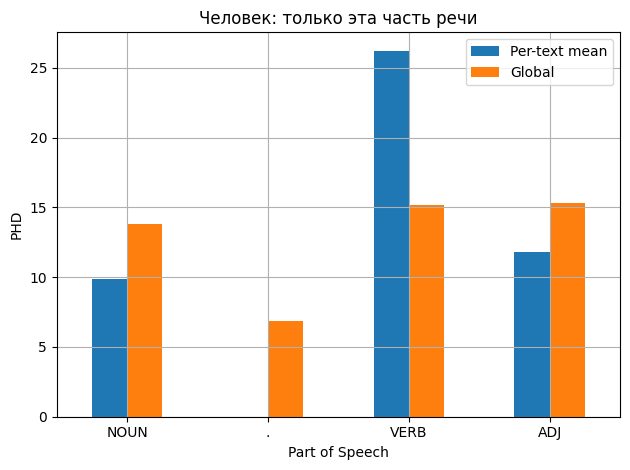

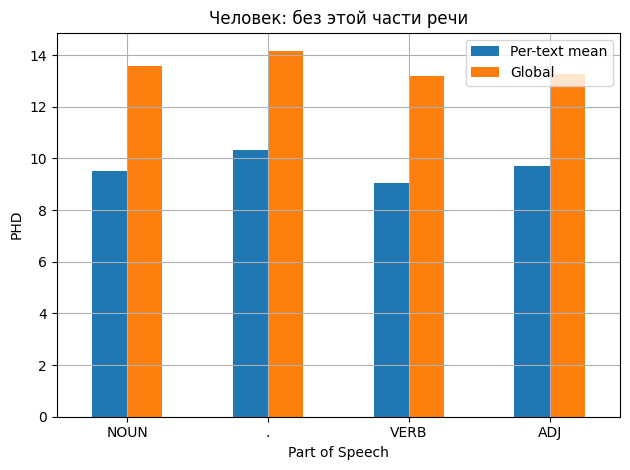

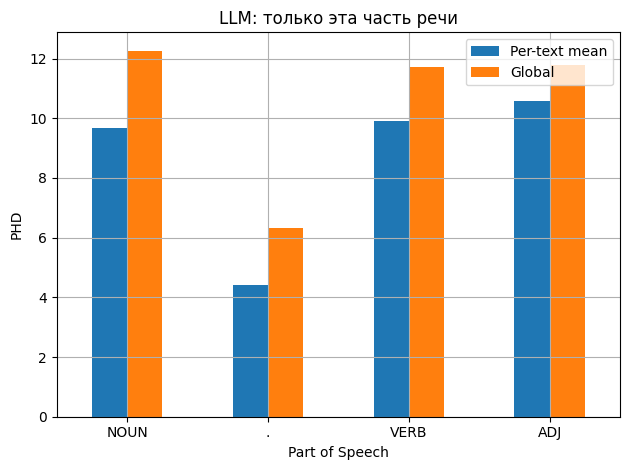

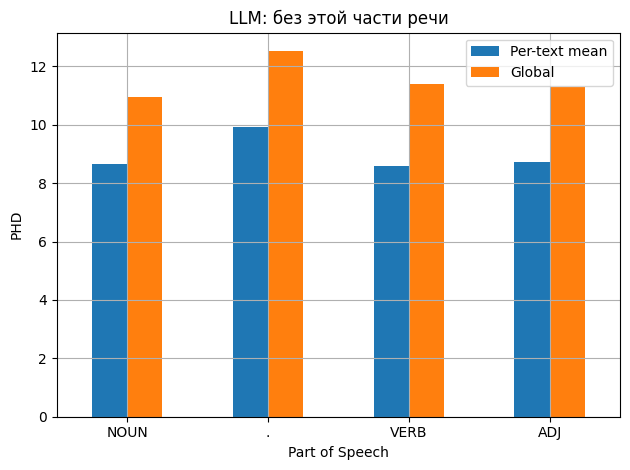

In [ ]:
plot_phd_comparison(pos_tags, phd_human_pertext_mean, phd_human_global_pos, "Человек: только эта часть речи")
plot_phd_comparison(pos_tags, phd_human_pertext_wo_mean, phd_human_global_wo, "Человек: без этой части речи")

plot_phd_comparison(pos_tags, phd_llm_pertext_mean, phd_llm_global_pos, "LLM: только эта часть речи")
plot_phd_comparison(pos_tags, phd_llm_pertext_wo_mean, phd_llm_global_wo, "LLM: без этой части речи")

На графике для человеческого текста, где используется только определенная часть речи отсутствует значение для среднего `per-text`, и оно же сильно завышено для глаголов. Скорее всего это связано с тем, что при недостижении порога в `MIN_TOKENS=47` мы пропускаем текст. Пунктуации в английских текстах используется мало, из-за чего не один текст не прошел порог. Нужно придумать идею, как считать PHD для малого размера текста.

## MLE

Для каждой точки $x_i$ считаются расстояния до $k$ ближайших соседей $r_{ij}$ и размерность d оценивается по формуле:

$$\hat{d_i} = \left[ \frac{1}{k-1}  \sum_{j = 1}^{k-1} log \frac{r_{ik}}{r_{ij}}\right]^{-1}$$

Итоговая оценка:

$$\hat{d} = \frac{1}{n}\sum_{i=1}^{n}\hat{d_i}$$

In [ ]:
from skdim.id import MLE

def mle_estimate_phd(embeds_sub, k=5):
    """
    Оценивает внутреннюю размерность (в духе PHD) с помощью MLE-метода Левины–Бикеля

    Аргументы:
    - embeds_sub: np.ndarray формы (n_points, embedding_dim) — эмбеддинги токенов
    - k: int — число ближайших соседей (по умолчанию 5)

    Возвращает:
    - float — оценка размерности manifold (MLE-интерпретация PHD)
    """
    embeds_sub = np.array(embeds_sub)
    if embeds_sub.ndim != 2:
        raise ValueError("embeds_sub должен быть 2D массивом: (n_points, embedding_dim)")

    if embeds_sub.shape[0] <= k:
        raise ValueError(f"Слишком мало токенов ({embeds_sub.shape[0]}), нужно хотя бы k+1={k+1}")

    model = MLE(K=k)
    dim = model.fit_transform(embeds_sub)

    return float(dim)

Адаптируем предыдущие функции под обработку текста с помощью `MLE` вместо простого пропуска.

In [ ]:
def compute_phd_by_pos_per_text(tokens_list, embeds_list, pos_tags=['NOUN', '.', 'VERB', 'ADJ'], min_tokens=MIN_TOKENS):
    """
    Считает PHD отдельно по каждой POS в каждом тексте,
    затем усредняет по всем текстам.

    Если POS < min_tokens, то fallback на MLE.

    Возвращает:
    - словарь {pos_tag: [list of phd values]} — для boxplot
    - словарь {pos_tag: float} — среднее значение по всем текстам
    - счётчики использования: {pos_tag: {'phd': int, 'mle': int}}
    """
    pos2phd_all = {pos: [] for pos in pos_tags}
    pos2count = {pos: {'phd': 0, 'mle': 0} for pos in pos_tags}

    for tokens, embeds in tqdm(zip(tokens_list, embeds_list)):
        tagged = nltk.pos_tag(tokens, tagset='universal')
        df = pd.DataFrame(tagged, columns=['token', 'pos'])
        df['embed'] = list(embeds)

        for pos in pos_tags:
            df_sub = df[df['pos'] == pos]
            embeds_sub = np.array(df_sub['embed'].tolist())

            try:
                if len(df_sub) >= min_tokens:
                    norm = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
                    phd = np.mean(get_raw_phd_in_loop(norm, n_tries=5))
                    pos2phd_all[pos].append(phd)
                    pos2count[pos]['phd'] += 1
                else:
                    phd = mle_estimate_phd(embeds_sub)
                    pos2phd_all[pos].append(phd)
                    pos2count[pos]['mle'] += 1
            except Exception as e:
                print(f"💥 compute_phd_by_pos_per_text — POS: {pos}, токенов: {len(df_sub)}, ошибка: {e}")
                continue

    pos2phd_mean = {pos: np.mean(vals) for pos, vals in pos2phd_all.items() if len(vals) > 0}
    return pos2phd_all, pos2phd_mean, pos2count


def compute_phd_without_pos_per_text(tokens_list, embeds_list, pos_tags=['NOUN', '.', 'VERB', 'ADJ'], min_tokens=MIN_TOKENS):
    """
    Считает PHD по всем токенам кроме заданного POS (поочерёдно),
    затем усредняет по всем текстам.

    Если POS-исключённый набор < min_tokens, то fallback на MLE.

    Возвращает:
    - словарь {pos_tag: [list of phd values]} — для boxplot
    - словарь {pos_tag: float} — среднее значение
    - счётчики использования: {pos_tag: {'phd': int, 'mle': int}}
    """
    pos2phd_all = {pos: [] for pos in pos_tags}
    pos2count = {pos: {'phd': 0, 'mle': 0} for pos in pos_tags}

    for tokens, embeds in tqdm(zip(tokens_list, embeds_list)):
        tagged = nltk.pos_tag(tokens, tagset='universal')
        df = pd.DataFrame(tagged, columns=['token', 'pos'])
        df['embed'] = list(embeds)

        for pos in pos_tags:
            df_sub = df[df['pos'] != pos]
            embeds_sub = np.array(df_sub['embed'].tolist())

            try:
                if len(df_sub) >= min_tokens:
                    norm = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
                    phd = np.mean(get_raw_phd_in_loop(norm, n_tries=5))
                    pos2phd_all[pos].append(phd)
                    pos2count[pos]['phd'] += 1
                else:
                    phd = mle_estimate_phd(embeds_sub)
                    pos2phd_all[pos].append(phd)
                    pos2count[pos]['mle'] += 1
            except Exception as e:
                print(f"💥 compute_phd_without_pos_per_text — POS: {pos}, токенов: {len(df_sub)}, ошибка: {e}")
                continue

    pos2phd_mean = {pos: np.mean(vals) for pos, vals in pos2phd_all.items() if len(vals) > 0}
    return pos2phd_all, pos2phd_mean, pos2count


def compute_phd_by_pos_global(tokens, embeds, pos_tags=['NOUN', '.', 'VERB', 'ADJ'], min_tokens=MIN_TOKENS):
    """
    Считает PHD отдельно по каждой POS в глобальном (pooled) стиле.
    Если токенов мало, применяет MLE.

    Возвращает:
    - словарь {pos_tag: phd_value}
    - счётчики {pos_tag: {'phd': int, 'mle': int}}
    """
    tagged = nltk.pos_tag(tokens, tagset='universal')
    df = pd.DataFrame(tagged, columns=['token', 'pos'])
    df['embed'] = list(embeds)

    pos2phd = {}
    pos2count = {pos: {'phd': 0, 'mle': 0} for pos in pos_tags}

    for pos in tqdm(pos_tags):
        df_sub = df[df['pos'] == pos]
        embeds_sub = np.array(df_sub['embed'].tolist())

        try:
            if len(df_sub) >= min_tokens:
                normed = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
                phd = np.mean(get_raw_phd_in_loop(normed, n_tries=5))
                pos2phd[pos] = phd
                pos2count[pos]['phd'] += 1
            else:
                phd = mle_estimate_phd(embeds_sub)
                pos2phd[pos] = phd
                pos2count[pos]['mle'] += 1
        except Exception as e:
            print(f"💥 compute_phd_by_pos_global — POS: {pos}, токенов: {len(df_sub)}, ошибка: {e}")
            continue

    return pos2phd, pos2count


def compute_phd_without_pos_global(tokens, embeds, pos_tags=['NOUN', '.', 'VERB', 'ADJ'], min_tokens=MIN_TOKENS):
    """
    Считает PHD по всем токенам, КРОМЕ заданной части речи (поочерёдно).
    Если токенов после исключения слишком мало, применяет MLE.

    Возвращает:
    - словарь {pos_tag: phd_value}
    - счётчики {pos_tag: {'phd': int, 'mle': int}}
    """
    tagged = nltk.pos_tag(tokens, tagset='universal')
    df = pd.DataFrame(tagged, columns=['token', 'pos'])
    df['embed'] = list(embeds)

    pos2phd = {}
    pos2count = {pos: {'phd': 0, 'mle': 0} for pos in pos_tags}

    for pos in tqdm(pos_tags):
        df_sub = df[df['pos'] != pos]
        embeds_sub = np.array(df_sub['embed'].tolist())

        try:
            if len(df_sub) >= min_tokens:
                normed = (embeds_sub + embeds_sub.min()) / (embeds_sub.max() - embeds_sub.min())
                phd = np.mean(get_raw_phd_in_loop(normed, n_tries=5))
                pos2phd[pos] = phd
                pos2count[pos]['phd'] += 1
            else:
                phd = mle_estimate_phd(embeds_sub)
                pos2phd[pos] = phd
                pos2count[pos]['mle'] += 1
        except Exception as e:
            print(f"💥 compute_phd_without_pos_global — POS: {pos}, токенов: {len(df_sub)}, ошибка: {e}")
            continue


    return pos2phd, pos2count


In [ ]:
def print_phd_mle_counts(counter_dict, title=""):
    """
    Выводит таблицу с количеством применений PHD и MLE по каждой POS.

    Аргументы:
    - counter_dict: словарь {POS: {'phd': int, 'mle': int}}
    - title: необязательный заголовок
    """
    df = pd.DataFrame.from_dict(counter_dict, orient='index')
    df = df.rename(columns={'phd': 'PHD count', 'mle': 'MLE count'})
    df['Total'] = df['PHD count'] + df['MLE count']
    df = df.sort_values(by='Total', ascending=False)

    if title:
        print(f"\n=== {title} ===")

    display(df.style.bar(subset=['PHD count', 'MLE count'], color='#5fba7d').format("{:.0f}"))


Запускаем сам эксперимент:

In [ ]:
pos_tags = ['NOUN', '.', 'VERB', 'ADJ']

embeds_llm, tokens_llm, embeds_llm_text, tokens_llm_text = get_embeds_and_tokens(df.query("label == 1"))
embeds_human, tokens_human, embeds_human_text, tokens_human_text = get_embeds_and_tokens(df.query("label == 0"))

100%|██████████| 24/24 [00:05<00:00,  4.08it/s]


In [ ]:
# --- LLM ---
phd_llm_global_pos, count_llm_global = compute_phd_by_pos_global(tokens_llm, embeds_llm, pos_tags)
phd_llm_global_wo, count_llm_global_wo = compute_phd_without_pos_global(tokens_llm, embeds_llm, pos_tags)

phd_llm_all, phd_llm_pertext_mean, count_llm = compute_phd_by_pos_per_text(tokens_llm_text, embeds_llm_text, pos_tags)
phd_llm_all_wo, phd_llm_pertext_wo_mean, count_llm_wo = compute_phd_without_pos_per_text(tokens_llm_text, embeds_llm_text, pos_tags)

  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  3407 point_jump =  481
input_shape: (3407, 768)
mn_points =  40 max_points =  3407 point_jump =  481
input_shape: (3407, 768)
mn_points =  40 max_points =  3407 point_jump =  481
input_shape: (3407, 768)
mn_points =  40 max_points =  3407 point_jump =  481
input_shape: (3407, 768)
mn_points =  40 max_points =  3407 point_jump =  481
input_shape: (3407, 768)


 25%|██▌       | 1/4 [01:37<04:53, 97.83s/it]

mn_points =  40 max_points =  558 point_jump =  74
input_shape: (558, 768)
mn_points =  40 max_points =  558 point_jump =  74
input_shape: (558, 768)
mn_points =  40 max_points =  558 point_jump =  74
input_shape: (558, 768)
mn_points =  40 max_points =  558 point_jump =  74
input_shape: (558, 768)
mn_points =  40 max_points =  558 point_jump =  74
input_shape: (558, 768)


 50%|█████     | 2/4 [01:41<01:24, 42.39s/it]

mn_points =  40 max_points =  754 point_jump =  102
input_shape: (754, 768)
mn_points =  40 max_points =  754 point_jump =  102
input_shape: (754, 768)
mn_points =  40 max_points =  754 point_jump =  102
input_shape: (754, 768)
mn_points =  40 max_points =  754 point_jump =  102
input_shape: (754, 768)
mn_points =  40 max_points =  754 point_jump =  102
input_shape: (754, 768)


 75%|███████▌  | 3/4 [01:46<00:25, 25.45s/it]

mn_points =  40 max_points =  715 point_jump =  96
input_shape: (715, 768)
mn_points =  40 max_points =  715 point_jump =  96
input_shape: (715, 768)
mn_points =  40 max_points =  715 point_jump =  96
input_shape: (715, 768)
mn_points =  40 max_points =  715 point_jump =  96
input_shape: (715, 768)
mn_points =  40 max_points =  715 point_jump =  96
input_shape: (715, 768)


  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  2441 point_jump =  343
input_shape: (2441, 768)
mn_points =  40 max_points =  2441 point_jump =  343
input_shape: (2441, 768)
mn_points =  40 max_points =  2441 point_jump =  343
input_shape: (2441, 768)
mn_points =  40 max_points =  2441 point_jump =  343
input_shape: (2441, 768)
mn_points =  40 max_points =  2441 point_jump =  343
input_shape: (2441, 768)


 25%|██▌       | 1/4 [00:47<02:23, 47.86s/it]

mn_points =  40 max_points =  5290 point_jump =  750
input_shape: (5290, 768)
mn_points =  40 max_points =  5290 point_jump =  750
input_shape: (5290, 768)
mn_points =  40 max_points =  5290 point_jump =  750
input_shape: (5290, 768)
mn_points =  40 max_points =  5290 point_jump =  750
input_shape: (5290, 768)
mn_points =  40 max_points =  5290 point_jump =  750
input_shape: (5290, 768)


 50%|█████     | 2/4 [06:06<06:54, 207.37s/it]

mn_points =  40 max_points =  5094 point_jump =  722
input_shape: (5094, 768)
mn_points =  40 max_points =  5094 point_jump =  722
input_shape: (5094, 768)
mn_points =  40 max_points =  5094 point_jump =  722
input_shape: (5094, 768)
mn_points =  40 max_points =  5094 point_jump =  722
input_shape: (5094, 768)
mn_points =  40 max_points =  5094 point_jump =  722
input_shape: (5094, 768)


 75%|███████▌  | 3/4 [11:05<04:09, 249.24s/it]

mn_points =  40 max_points =  5133 point_jump =  727
input_shape: (5133, 768)
mn_points =  40 max_points =  5133 point_jump =  727
input_shape: (5133, 768)
mn_points =  40 max_points =  5133 point_jump =  727
input_shape: (5133, 768)
mn_points =  40 max_points =  5133 point_jump =  727
input_shape: (5133, 768)
mn_points =  40 max_points =  5133 point_jump =  727
input_shape: (5133, 768)


100%|██████████| 4/4 [19:14<00:00, 288.53s/it]
0it [00:00, ?it/s]

mn_points =  40 max_points =  276 point_jump =  33
input_shape: (276, 768)
mn_points =  40 max_points =  276 point_jump =  33
input_shape: (276, 768)
mn_points =  40 max_points =  276 point_jump =  33
input_shape: (276, 768)
mn_points =  40 max_points =  276 point_jump =  33
input_shape: (276, 768)
mn_points =  40 max_points =  276 point_jump =  33
input_shape: (276, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2


1it [00:02,  2.29s/it]

mn_points =  40 max_points =  237 point_jump =  28
input_shape: (237, 768)
mn_points =  40 max_points =  237 point_jump =  28
input_shape: (237, 768)
mn_points =  40 max_points =  237 point_jump =  28
input_shape: (237, 768)
mn_points =  40 max_points =  237 point_jump =  28
input_shape: (237, 768)
mn_points =  40 max_points =  237 point_jump =  28
input_shape: (237, 768)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 768)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 768)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 768)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 768)
mn_points =  40 max_points =  55 point_jump =  2
input_shape: (55, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)


2it [00:04,  2.10s/it]

mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 768)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 768)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 768)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 768)
mn_points =  40 max_points =  200 point_jump =  22
input_shape: (200, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  62 point_jump =  3
input_shape: (62, 768)
mn_points =  40 max_points =  62 point_jump =  3


3it [00:06,  1.97s/it]

mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)


4it [00:06,  1.35s/it]

mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  209 point_jump =  24
input_shape: (209, 768)
mn_points =  40 max_points =  209 point_jump =  24
input_shape: (209, 768)
mn_points =  40 max_points =  209 point_jump =  24
input_shape: (209, 768)
mn_points =  40 max_points =  209 point_jump =  24
input_shape: (209, 768)
mn_points =  40 max_points =  209 point_jump =  24
input_shape: (209, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)


6it [00:08,  1.07s/it]

mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)


7it [00:09,  1.23s/it]

mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 4, ошибка: Слишком мало токенов (4), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 5, ошибка: Слишком мало токенов (5), нужно хотя бы k+1=6
mn_points =  40 max_points =  241 point_jump =  28
input_shape: (241, 768)
mn_points =  40 max_points =  241 point_jump =  28
input_shape: (241, 768)
mn_points =  40 max_points =  241 point_jump =  28
input_shape: (241, 768)
mn_points =  40 max_points =  241 point_jump =  28
input_shape: (241, 768)
mn_points =  40 max_points =  241 point_jump =  28
input_shape: (241, 768)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 768)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 768)
mn_points =  40 max_points =  53 point_jump =  1

9it [00:11,  1.09s/it]

mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 768)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 768)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 768)
mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 768)


10it [00:12,  1.02it/s]

mn_points =  40 max_points =  102 point_jump =  8
input_shape: (102, 768)
mn_points =  40 max_points =  209 point_jump =  24
input_shape: (209, 768)
mn_points =  40 max_points =  209 point_jump =  24
input_shape: (209, 768)
mn_points =  40 max_points =  209 point_jump =  24
input_shape: (209, 768)
mn_points =  40 max_points =  209 point_jump =  24
input_shape: (209, 768)
mn_points =  40 max_points =  209 point_jump =  24
input_shape: (209, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)


11it [00:13,  1.11s/it]

mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 768)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 768)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 768)


12it [00:14,  1.10it/s]

mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 768)
mn_points =  40 max_points =  79 point_jump =  5
input_shape: (79, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)


13it [00:14,  1.26it/s]

mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
💥 compute_phd_by_pos_per_text — POS: ., токенов: 5, ошибка: Слишком мало токенов (5), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 5, ошибка: Слишком мало токенов (5), нужно хотя бы k+1=6
mn_points =  40 max_points =  242 point_jump =  28
input_shape: (242, 768)
mn_points =  40 max_points =  242 point_jump =  28
input_shape: (242, 768)
mn_points =  40 max_points =  242 point_jump =  28
input_shape: (242, 768)
mn_points =  40 max_points =  242 point_jump =  28
input_shape: (242, 768)
mn_points =  40 max_points =  242 point_jump =  28
input_shape: (242, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
i

16it [00:16,  1.41it/s]

mn_points =  40 max_points =  61 point_jump =  3
input_shape: (61, 768)
mn_points =  40 max_points =  287 point_jump =  35
input_shape: (287, 768)
mn_points =  40 max_points =  287 point_jump =  35
input_shape: (287, 768)
mn_points =  40 max_points =  287 point_jump =  35
input_shape: (287, 768)
mn_points =  40 max_points =  287 point_jump =  35
input_shape: (287, 768)
mn_points =  40 max_points =  287 point_jump =  35
input_shape: (287, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)


17it [00:18,  1.02it/s]

mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  221 point_jump =  25
input_shape: (221, 768)
mn_points =  40 max_points =  221 point_jump =  25
input_shape: (221, 768)
mn_points =  40 max_points =  221 point_jump =  25
input_shape: (221, 768)
mn_points =  40 max_points =  221 point_jump =  25
input_shape: (221, 768)
mn_points =  40 max_points =  221 point_jump =  25
input_shape: (221, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)


18it [00:20,  1.14s/it]

mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 768)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 768)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 768)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 768)
mn_points =  40 max_points =  183 point_jump =  20
input_shape: (183, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)


19it [00:21,  1.22s/it]

mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  219 point_jump =  25
input_shape: (219, 768)
mn_points =  40 max_points =  219 point_jump =  25
input_shape: (219, 768)
mn_points =  40 max_points =  219 point_jump =  25
input_shape: (219, 768)
mn_points =  40 max_points =  219 point_jump =  25
input_shape: (219, 768)
mn_points =  40 max_points =  219 point_jump =  25
input_shape: (219, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1


20it [00:23,  1.39s/it]

mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  124 point_jump =  12
input_shape: (124, 768)
mn_points =  40 max_points =  124 point_jump =  12
input_shape: (124, 768)
mn_points =  40 max_points =  124 point_jump =  12
input_shape: (124, 768)
mn_points =  40 max_points =  124 point_jump =  12
input_shape: (124, 768)
mn_points =  40 max_points =  124 point_jump =  12
input_shape: (124, 768)


21it [00:24,  1.18s/it]

💥 compute_phd_by_pos_per_text — POS: ., токенов: 3, ошибка: Слишком мало токенов (3), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 4, ошибка: Слишком мало токенов (4), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 1, ошибка: Слишком мало токенов (1), нужно хотя бы k+1=6
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)


24it [00:24,  1.03s/it]


mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 5, ошибка: Слишком мало токенов (5), нужно хотя бы k+1=6


0it [00:00, ?it/s]

mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  225 point_jump =  26
input_shape: (225, 768)
mn_points =  40 max_points =  460 point_jump =  60
input_shape: (460, 768)
mn_points =  40 max_points =  460 point_jump =  60
input_shape: (460, 768)
mn_points =  40 max_points =  460 point_jump =  60
input_shape: (460, 768)
mn_points =  40 max_points =  460 point_jump =  60
input_shape: (460, 768)
mn_points =  40 max_points =  460 point_jump =  60
input_shape: (460, 768)
mn_points =  40 max_points =  437 point_jump =  56
input_shape: (437, 768)
mn_points =  40 max_points =  437 point_jump =  56
input_shape: (437, 768)
mn_points =  40 max_points =  437 point_jump =  56
input_shape: (437, 768)
mn_points =  40 max_point

1it [00:10, 10.73s/it]

mn_points =  40 max_points =  178 point_jump =  19
input_shape: (178, 768)
mn_points =  40 max_points =  178 point_jump =  19
input_shape: (178, 768)
mn_points =  40 max_points =  178 point_jump =  19
input_shape: (178, 768)
mn_points =  40 max_points =  178 point_jump =  19
input_shape: (178, 768)
mn_points =  40 max_points =  178 point_jump =  19
input_shape: (178, 768)
mn_points =  40 max_points =  374 point_jump =  47
input_shape: (374, 768)
mn_points =  40 max_points =  374 point_jump =  47
input_shape: (374, 768)
mn_points =  40 max_points =  374 point_jump =  47
input_shape: (374, 768)
mn_points =  40 max_points =  374 point_jump =  47
input_shape: (374, 768)
mn_points =  40 max_points =  374 point_jump =  47
input_shape: (374, 768)
mn_points =  40 max_points =  360 point_jump =  45
input_shape: (360, 768)
mn_points =  40 max_points =  360 point_jump =  45
input_shape: (360, 768)
mn_points =  40 max_points =  360 point_jump =  45
input_shape: (360, 768)
mn_points =  40 max_point

2it [00:19,  9.41s/it]

mn_points =  40 max_points =  169 point_jump =  18
input_shape: (169, 768)
mn_points =  40 max_points =  169 point_jump =  18
input_shape: (169, 768)
mn_points =  40 max_points =  169 point_jump =  18
input_shape: (169, 768)
mn_points =  40 max_points =  169 point_jump =  18
input_shape: (169, 768)
mn_points =  40 max_points =  169 point_jump =  18
input_shape: (169, 768)
mn_points =  40 max_points =  335 point_jump =  42
input_shape: (335, 768)
mn_points =  40 max_points =  335 point_jump =  42
input_shape: (335, 768)
mn_points =  40 max_points =  335 point_jump =  42
input_shape: (335, 768)
mn_points =  40 max_points =  335 point_jump =  42
input_shape: (335, 768)
mn_points =  40 max_points =  335 point_jump =  42
input_shape: (335, 768)
mn_points =  40 max_points =  320 point_jump =  40
input_shape: (320, 768)
mn_points =  40 max_points =  320 point_jump =  40
input_shape: (320, 768)
mn_points =  40 max_points =  320 point_jump =  40
input_shape: (320, 768)
mn_points =  40 max_point

3it [00:25,  8.07s/it]

mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 768)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 768)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 768)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 768)
mn_points =  40 max_points =  108 point_jump =  9
input_shape: (108, 768)
mn_points =  40 max_points =  104 point_jump =  9
input_shape: (104, 768)
mn_points =  40 max_points =  104 point_jump =  9
input_shape: (104, 768)
mn_points =  40 max_points =  104 point_jump =  9
input_shape: (104, 768)
mn_points =  40 max_points =  104 point_jump =  

4it [00:28,  5.88s/it]

mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 768)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 768)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 768)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 768)
mn_points =  40 max_points =  53 point_jump =  1
input_shape: (53, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)


5it [00:29,  4.29s/it]

mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 768)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 768)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 768)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 768)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 768)
mn_points =  40 max_points =  314 point_jump =  39
input_shape: (314, 768)
mn_points =  40 max_points =  314 point_jump =  39
input_shape: (314, 768)
mn_points =  40 max_points =  314 point_jump =  39
input_shape: (314, 768)
mn_points =  40 max_points =  314 point_jump =  39
input_shape: (314, 768)
mn_points =  40 max_points =  314 point_jump =  39
input_shape: (314, 768)
mn_points =  40 max_points =  298 point_jump =  36
input_shape: (298, 768)
mn_points =  40 max_points =  2

6it [00:36,  5.01s/it]

mn_points =  40 max_points =  167 point_jump =  18
input_shape: (167, 768)
mn_points =  40 max_points =  167 point_jump =  18
input_shape: (167, 768)
mn_points =  40 max_points =  167 point_jump =  18
input_shape: (167, 768)
mn_points =  40 max_points =  167 point_jump =  18
input_shape: (167, 768)
mn_points =  40 max_points =  167 point_jump =  18
input_shape: (167, 768)
mn_points =  40 max_points =  319 point_jump =  39
input_shape: (319, 768)
mn_points =  40 max_points =  319 point_jump =  39
input_shape: (319, 768)
mn_points =  40 max_points =  319 point_jump =  39
input_shape: (319, 768)
mn_points =  40 max_points =  319 point_jump =  39
input_shape: (319, 768)
mn_points =  40 max_points =  319 point_jump =  39
input_shape: (319, 768)
mn_points =  40 max_points =  299 point_jump =  37
input_shape: (299, 768)
mn_points =  40 max_points =  299 point_jump =  37
input_shape: (299, 768)
mn_points =  40 max_points =  299 point_jump =  37
input_shape: (299, 768)
mn_points =  40 max_point

7it [00:42,  5.38s/it]

mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)


8it [00:43,  4.02s/it]

mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 768)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 768)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 768)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 768)
mn_points =  40 max_points =  161 point_jump =  17
input_shape: (161, 768)
mn_points =  40 max_points =  368 point_jump =  46
input_shape: (368, 768)
mn_points =  40 max_points =  368 point_jump =  46
input_shape: (368, 768)
mn_points =  40 max_points =  368 point_jump =  46
input_shape: (368, 768)
mn_points =  40 max_points =  368 point_jump =  46
input_shape: (368, 768)
mn_points =  40 max_points =  368 point_jump =  46
input_shape: (368, 768)
mn_points =  40 max_points =  356 point_jump =  45
input_shape: (356, 768)
mn_points =  40 max_points =  3

9it [00:51,  5.38s/it]

mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_jump =  15
input_shape: (147, 768)
mn_points =  40 max_points =  147 point_

10it [00:54,  4.69s/it]

mn_points =  40 max_points =  143 point_jump =  14
input_shape: (143, 768)
mn_points =  40 max_points =  138 point_jump =  14
input_shape: (138, 768)
mn_points =  40 max_points =  138 point_jump =  14
input_shape: (138, 768)
mn_points =  40 max_points =  138 point_jump =  14
input_shape: (138, 768)
mn_points =  40 max_points =  138 point_jump =  14
input_shape: (138, 768)
mn_points =  40 max_points =  138 point_jump =  14
input_shape: (138, 768)
mn_points =  40 max_points =  325 point_jump =  40
input_shape: (325, 768)
mn_points =  40 max_points =  325 point_jump =  40
input_shape: (325, 768)
mn_points =  40 max_points =  325 point_jump =  40
input_shape: (325, 768)
mn_points =  40 max_points =  325 point_jump =  40
input_shape: (325, 768)
mn_points =  40 max_points =  325 point_jump =  40
input_shape: (325, 768)
mn_points =  40 max_points =  300 point_jump =  37
input_shape: (300, 768)
mn_points =  40 max_points =  300 point_jump =  37
input_shape: (300, 768)
mn_points =  40 max_point

11it [01:01,  5.29s/it]

mn_points =  40 max_points =  109 point_jump =  9
input_shape: (109, 768)
mn_points =  40 max_points =  109 point_jump =  9
input_shape: (109, 768)
mn_points =  40 max_points =  109 point_jump =  9
input_shape: (109, 768)
mn_points =  40 max_points =  109 point_jump =  9
input_shape: (109, 768)
mn_points =  40 max_points =  109 point_jump =  9
input_shape: (109, 768)
mn_points =  40 max_points =  109 point_jump =  9
input_shape: (109, 768)
mn_points =  40 max_points =  109 point_jump =  9
input_shape: (109, 768)
mn_points =  40 max_points =  109 point_jump =  9
input_shape: (109, 768)
mn_points =  40 max_points =  109 point_jump =  9
input_shape: (109, 768)
mn_points =  40 max_points =  109 point_jump =  9
input_shape: (109, 768)
mn_points =  40 max_points =  113 point_jump =  10
input_shape: (113, 768)
mn_points =  40 max_points =  113 point_jump =  10
input_shape: (113, 768)
mn_points =  40 max_points =  113 point_jump =  10
input_shape: (113, 768)
mn_points =  40 max_points =  113 p

12it [01:03,  4.31s/it]

mn_points =  40 max_points =  113 point_jump =  10
input_shape: (113, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  138 point_jump =  14
input_shape: (138, 768)
mn_points =  40 max_points =  138 point_jump =  14
input_shape: (138, 768)
mn_points =  40 max_points =  138 point_

13it [01:06,  3.96s/it]

mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (58, 768)
mn_points =  40 max_points =  58 point_jump =  2
input_shape: (5

15it [01:07,  2.38s/it]

mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  375 point_jump =  47
input_shape: (375, 768)
mn_points =  40 max_points =  361 point_jump =  45
input_shape: (361, 768)
mn_points =  40 max_points =  361 point_jump =  45
input_shape: (361, 768)
mn_points =  40 max_points =  361 point_jump =  45
input_shape: (361, 768)
mn_points =  40 max_point

16it [01:16,  3.88s/it]

mn_points =  40 max_points =  156 point_jump =  16
input_shape: (156, 768)
mn_points =  40 max_points =  156 point_jump =  16
input_shape: (156, 768)
mn_points =  40 max_points =  156 point_jump =  16
input_shape: (156, 768)
mn_points =  40 max_points =  156 point_jump =  16
input_shape: (156, 768)
mn_points =  40 max_points =  156 point_jump =  16
input_shape: (156, 768)
mn_points =  40 max_points =  395 point_jump =  50
input_shape: (395, 768)
mn_points =  40 max_points =  395 point_jump =  50
input_shape: (395, 768)
mn_points =  40 max_points =  395 point_jump =  50
input_shape: (395, 768)
mn_points =  40 max_points =  395 point_jump =  50
input_shape: (395, 768)
mn_points =  40 max_points =  395 point_jump =  50
input_shape: (395, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_point

17it [01:25,  5.28s/it]

mn_points =  40 max_points =  151 point_jump =  15
input_shape: (151, 768)
mn_points =  40 max_points =  151 point_jump =  15
input_shape: (151, 768)
mn_points =  40 max_points =  151 point_jump =  15
input_shape: (151, 768)
mn_points =  40 max_points =  151 point_jump =  15
input_shape: (151, 768)
mn_points =  40 max_points =  151 point_jump =  15
input_shape: (151, 768)
mn_points =  40 max_points =  336 point_jump =  42
input_shape: (336, 768)
mn_points =  40 max_points =  336 point_jump =  42
input_shape: (336, 768)
mn_points =  40 max_points =  336 point_jump =  42
input_shape: (336, 768)
mn_points =  40 max_points =  336 point_jump =  42
input_shape: (336, 768)
mn_points =  40 max_points =  336 point_jump =  42
input_shape: (336, 768)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 768)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 768)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 768)
mn_points =  40 max_point

18it [01:32,  5.83s/it]

mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  136 point_jump =  13
input_shape: (136, 768)
mn_points =  40 max_points =  289 point_jump =  35
input_shape: (289, 768)
mn_points =  40 max_points =  289 point_jump =  35
input_shape: (289, 768)
mn_points =  40 max_points =  289 point_jump =  35
input_shape: (289, 768)
mn_points =  40 max_points =  289 point_jump =  35
input_shape: (289, 768)
mn_points =  40 max_points =  289 point_jump =  35
input_shape: (289, 768)
mn_points =  40 max_points =  269 point_jump =  32
input_shape: (269, 768)
mn_points =  40 max_points =  269 point_jump =  32
input_shape: (269, 768)
mn_points =  40 max_points =  269 point_jump =  32
input_shape: (269, 768)
mn_points =  40 max_point

19it [01:38,  5.69s/it]

mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 768)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 768)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 768)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 768)
mn_points =  40 max_points =  328 point_jump =  41
input_shape: (328, 768)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 768)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 768)
mn_points =  40 max_points =  329 point_jump =  41
input_shape: (329, 768)
mn_points =  40 max_point

20it [01:45,  6.21s/it]

mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  174 point_jump =  19
input_shape: (174, 768)
mn_points =  40 max_points =  174 point_jump =  19
input_shape: (174, 768)
mn_points =  40 max_points =  174 point_jump =  19
input_shape: (174, 768)
mn_points =  40 max_points =  174 point_jump =  19
input_shape: (174, 768)
mn_points =  40 max_points =  174 point_jump =  19
input_shape: (174, 768)
mn_points =  40 max_points =  168 point_jump =  18
input_shape: (168, 768)
mn_points =  40 max_points =  168 point_jump =  18
input_shape: (168, 768)
mn_points =  40 max_points =  168 point_jump =  18
input_shape: (168, 768)
mn_points =  40 max_points =  168 point_

21it [01:48,  5.33s/it]

mn_points =  40 max_points =  173 point_jump =  19
input_shape: (173, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  54 point_jump =  2
input_shape: (54, 768)
mn_points =  40 max_points =  92 point_jump =  7
input_shape: (92, 768)
mn_points =  40 max_points =  92 point_jump =  7
input_shape: (92, 768)
mn_points =  40 max_points =  92 point_jump =  7
input_shape: (92, 768)
mn_points =  40 max_points =  92 point_jump =  7
input_shape: (92, 768)
mn_points =  40 max_points =  92 point_jump =  7
input_shape: (92, 768)
mn_points =  40 max_points =  89 point_jump =  7
input_shape: (89, 768)
mn_points =  40 max_points =  89 point_jump =  7
input_shape: (89, 768)
mn_points =  40 max_points =  89 point_jump =  7
input_shape:

23it [01:50,  3.27s/it]

mn_points =  40 max_points =  87 point_jump =  6
input_shape: (87, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (4

24it [01:51,  4.64s/it]

mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)


In [ ]:
# --- Human ---
phd_human_global_pos, count_human_global = compute_phd_by_pos_global(tokens_human, embeds_human, pos_tags)
phd_human_global_wo, count_human_global_wo = compute_phd_without_pos_global(tokens_human, embeds_human, pos_tags)

phd_human_all, phd_human_pertext_mean, count_human = compute_phd_by_pos_per_text(tokens_human_text, embeds_human_text, pos_tags)
phd_human_all_wo, phd_human_pertext_wo_mean, count_human_wo = compute_phd_without_pos_per_text(tokens_human_text, embeds_human_text, pos_tags)

  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  3238 point_jump =  456
input_shape: (3238, 768)
mn_points =  40 max_points =  3238 point_jump =  456
input_shape: (3238, 768)
mn_points =  40 max_points =  3238 point_jump =  456
input_shape: (3238, 768)
mn_points =  40 max_points =  3238 point_jump =  456
input_shape: (3238, 768)
mn_points =  40 max_points =  3238 point_jump =  456
input_shape: (3238, 768)


 25%|██▌       | 1/4 [02:17<06:51, 137.23s/it]

mn_points =  40 max_points =  554 point_jump =  73
input_shape: (554, 768)
mn_points =  40 max_points =  554 point_jump =  73
input_shape: (554, 768)
mn_points =  40 max_points =  554 point_jump =  73
input_shape: (554, 768)
mn_points =  40 max_points =  554 point_jump =  73
input_shape: (554, 768)
mn_points =  40 max_points =  554 point_jump =  73
input_shape: (554, 768)


 50%|█████     | 2/4 [02:21<01:58, 59.13s/it] 

mn_points =  40 max_points =  707 point_jump =  95
input_shape: (707, 768)
mn_points =  40 max_points =  707 point_jump =  95
input_shape: (707, 768)
mn_points =  40 max_points =  707 point_jump =  95
input_shape: (707, 768)
mn_points =  40 max_points =  707 point_jump =  95
input_shape: (707, 768)
mn_points =  40 max_points =  707 point_jump =  95
input_shape: (707, 768)


 75%|███████▌  | 3/4 [02:28<00:35, 35.16s/it]

mn_points =  40 max_points =  580 point_jump =  77
input_shape: (580, 768)
mn_points =  40 max_points =  580 point_jump =  77
input_shape: (580, 768)
mn_points =  40 max_points =  580 point_jump =  77
input_shape: (580, 768)
mn_points =  40 max_points =  580 point_jump =  77
input_shape: (580, 768)
mn_points =  40 max_points =  580 point_jump =  77
input_shape: (580, 768)


  0%|          | 0/4 [00:00<?, ?it/s]

mn_points =  40 max_points =  2221 point_jump =  311
input_shape: (2221, 768)
mn_points =  40 max_points =  2221 point_jump =  311
input_shape: (2221, 768)
mn_points =  40 max_points =  2221 point_jump =  311
input_shape: (2221, 768)
mn_points =  40 max_points =  2221 point_jump =  311
input_shape: (2221, 768)
mn_points =  40 max_points =  2221 point_jump =  311
input_shape: (2221, 768)


 25%|██▌       | 1/4 [00:55<02:45, 55.20s/it]

mn_points =  40 max_points =  4905 point_jump =  695
input_shape: (4905, 768)
mn_points =  40 max_points =  4905 point_jump =  695
input_shape: (4905, 768)
mn_points =  40 max_points =  4905 point_jump =  695
input_shape: (4905, 768)
mn_points =  40 max_points =  4905 point_jump =  695
input_shape: (4905, 768)
mn_points =  40 max_points =  4905 point_jump =  695
input_shape: (4905, 768)


 50%|█████     | 2/4 [05:21<05:58, 179.36s/it]

mn_points =  40 max_points =  4752 point_jump =  673
input_shape: (4752, 768)
mn_points =  40 max_points =  4752 point_jump =  673
input_shape: (4752, 768)
mn_points =  40 max_points =  4752 point_jump =  673
input_shape: (4752, 768)
mn_points =  40 max_points =  4752 point_jump =  673
input_shape: (4752, 768)
mn_points =  40 max_points =  4752 point_jump =  673
input_shape: (4752, 768)


 75%|███████▌  | 3/4 [11:58<04:38, 278.94s/it]

mn_points =  40 max_points =  4879 point_jump =  691
input_shape: (4879, 768)
mn_points =  40 max_points =  4879 point_jump =  691
input_shape: (4879, 768)
mn_points =  40 max_points =  4879 point_jump =  691
input_shape: (4879, 768)
mn_points =  40 max_points =  4879 point_jump =  691
input_shape: (4879, 768)
mn_points =  40 max_points =  4879 point_jump =  691
input_shape: (4879, 768)


100%|██████████| 4/4 [19:09<00:00, 287.28s/it]
0it [00:00, ?it/s]

mn_points =  40 max_points =  140 point_jump =  14
input_shape: (140, 768)
mn_points =  40 max_points =  140 point_jump =  14
input_shape: (140, 768)
mn_points =  40 max_points =  140 point_jump =  14
input_shape: (140, 768)
mn_points =  40 max_points =  140 point_jump =  14
input_shape: (140, 768)


1it [00:00,  1.26it/s]

mn_points =  40 max_points =  140 point_jump =  14
input_shape: (140, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)


2it [00:01,  1.82it/s]

mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 768)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 768)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 768)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 768)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)


3it [00:02,  1.05s/it]

mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  51 point_jump =  1
input_shape: (51, 768)
mn_points =  40 max_points =  230 point_jump =  27
input_shape: (230, 768)
mn_points =  40 max_points =  230 point_jump =  27
input_shape: (230, 768)
mn_points =  40 max_points =  230 point_jump =  27
input_shape: (230, 768)
mn_points =  40 max_points =  230 point_jump =  27
input_shape: (230, 768)
mn_points =  40 max_points =  230 point_jump =  27
input_shape: (230, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  56 point_jump =  2
input_shape: (56, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3


5it [00:04,  1.00it/s]

mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  64 point_jump =  3
input_shape: (64, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)


7it [00:05,  1.38it/s]

mn_points =  40 max_points =  129 point_jump =  12
input_shape: (129, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)


8it [00:06,  1.19it/s]

mn_points =  40 max_points =  220 point_jump =  25
input_shape: (220, 768)
mn_points =  40 max_points =  220 point_jump =  25
input_shape: (220, 768)
mn_points =  40 max_points =  220 point_jump =  25
input_shape: (220, 768)
mn_points =  40 max_points =  220 point_jump =  25
input_shape: (220, 768)
mn_points =  40 max_points =  220 point_jump =  25
input_shape: (220, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1


9it [00:08,  1.14s/it]

mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 4, ошибка: Слишком мало токенов (4), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 2, ошибка: Слишком мало токенов (2), нужно хотя бы k+1=6
mn_points =  40 max_points =  172 point_jump =  18
input_shape: (172, 768)
mn_points =  40 max_points =  172 point_jump =  18
input_shape: (172, 768)
mn_points =  40 max_points =  172 point_jump =  18
input_shape: (172, 768)
mn_points =  40 max_points =  172 point_jump =  18
input_shape: (172, 768)
mn_points =  40 max_points =  172 point_jump =  18
input_shape: (172, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)


11it [00:09,  1.10it/s]

mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  78 point_jump =  5
input_shape: (78, 768)
mn_points =  40 max_points =  78 point_jump =  5
input_shape: (78, 768)
mn_points =  40 max_points =  78 point_jump =  5
input_shape: (78, 768)


12it [00:10,  1.28it/s]

mn_points =  40 max_points =  78 point_jump =  5
input_shape: (78, 768)
mn_points =  40 max_points =  78 point_jump =  5
input_shape: (78, 768)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 768)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 768)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 768)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 768)
mn_points =  40 max_points =  201 point_jump =  23
input_shape: (201, 768)


13it [00:11,  1.24it/s]

mn_points =  40 max_points =  164 point_jump =  17
input_shape: (164, 768)
mn_points =  40 max_points =  164 point_jump =  17
input_shape: (164, 768)
mn_points =  40 max_points =  164 point_jump =  17
input_shape: (164, 768)
mn_points =  40 max_points =  164 point_jump =  17
input_shape: (164, 768)


14it [00:12,  1.18it/s]

mn_points =  40 max_points =  164 point_jump =  17
input_shape: (164, 768)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 768)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 768)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 768)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 768)
mn_points =  40 max_points =  111 point_jump =  10
input_shape: (111, 768)


15it [00:12,  1.27it/s]

mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)
mn_points =  40 max_points =  163 point_jump =  17
input_shape: (163, 768)


16it [00:13,  1.22it/s]

mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)
mn_points =  40 max_points =  180 point_jump =  20
input_shape: (180, 768)


17it [00:14,  1.19it/s]

mn_points =  40 max_points =  153 point_jump =  16
input_shape: (153, 768)
mn_points =  40 max_points =  153 point_jump =  16
input_shape: (153, 768)
mn_points =  40 max_points =  153 point_jump =  16
input_shape: (153, 768)
mn_points =  40 max_points =  153 point_jump =  16
input_shape: (153, 768)
mn_points =  40 max_points =  153 point_jump =  16
input_shape: (153, 768)


18it [00:15,  1.12it/s]

mn_points =  40 max_points =  265 point_jump =  32
input_shape: (265, 768)
mn_points =  40 max_points =  265 point_jump =  32
input_shape: (265, 768)
mn_points =  40 max_points =  265 point_jump =  32
input_shape: (265, 768)
mn_points =  40 max_points =  265 point_jump =  32
input_shape: (265, 768)
mn_points =  40 max_points =  265 point_jump =  32
input_shape: (265, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  60 point_jump =  2
input_shape: (60, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)


19it [00:17,  1.27s/it]

mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
mn_points =  40 max_points =  48 point_jump =  1
input_shape: (48, 768)
💥 compute_phd_by_pos_per_text — POS: ., токенов: 0, ошибка: embeds_sub должен быть 2D массивом: (n_points, embedding_dim)
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 1, ошибка: Слишком мало токенов (1), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 0, ошибка: embeds_sub должен быть 2D массивом: (n_points, embedding_dim)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)
mn_points =  40 max_points =  49 point_jump =  1
input_shape: (49, 768)


21it [00:18,  1.30it/s]

💥 compute_phd_by_pos_per_text — POS: ., токенов: 0, ошибка: embeds_sub должен быть 2D массивом: (n_points, embedding_dim)
💥 compute_phd_by_pos_per_text — POS: VERB, токенов: 2, ошибка: Слишком мало токенов (2), нужно хотя бы k+1=6
💥 compute_phd_by_pos_per_text — POS: ADJ, токенов: 3, ошибка: Слишком мало токенов (3), нужно хотя бы k+1=6
mn_points =  40 max_points =  154 point_jump =  16
input_shape: (154, 768)
mn_points =  40 max_points =  154 point_jump =  16
input_shape: (154, 768)
mn_points =  40 max_points =  154 point_jump =  16
input_shape: (154, 768)
mn_points =  40 max_points =  154 point_jump =  16
input_shape: (154, 768)
mn_points =  40 max_points =  154 point_jump =  16
input_shape: (154, 768)


23it [00:19,  1.53it/s]

mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 768)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 768)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 768)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 768)
mn_points =  40 max_points =  226 point_jump =  26
input_shape: (226, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)
mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)


24it [00:20,  1.17it/s]


mn_points =  40 max_points =  47 point_jump =  1
input_shape: (47, 768)


0it [00:00, ?it/s]

mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  70 point_jump =  4
input_shape: (70, 768)
mn_points =  40 max_points =  195 point_jump =  22
input_shape: (195, 768)
mn_points =  40 max_points =  195 point_jump =  22
input_shape: (195, 768)
mn_points =  40 max_points =  195 point_jump =  22
input_shape: (195, 768)
mn_points =  40 max_points =  195 point_jump =  22
input_shape: (195, 768)
mn_points =  40 max_points =  195 point_jump =  22
input_shape: (195, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_jump =  20
input_shape: (182, 768)
mn_points =  40 max_points =  182 point_

1it [00:03,  3.56s/it]

mn_points =  40 max_points =  95 point_jump =  7
input_shape: (95, 768)
mn_points =  40 max_points =  95 point_jump =  7
input_shape: (95, 768)
mn_points =  40 max_points =  95 point_jump =  7
input_shape: (95, 768)
mn_points =  40 max_points =  95 point_jump =  7
input_shape: (95, 768)
mn_points =  40 max_points =  95 point_jump =  7
input_shape: (95, 768)
mn_points =  40 max_points =  91 point_jump =  7
input_shape: (91, 768)
mn_points =  40 max_points =  91 point_jump =  7
input_shape: (91, 768)
mn_points =  40 max_points =  91 point_jump =  7
input_shape: (91, 768)
mn_points =  40 max_points =  91 point_jump =  7
input_shape: (91, 768)
mn_points =  40 max_points =  91 point_jump =  7
input_shape: (91, 768)
mn_points =  40 max_points =  92 point_jump =  7
input_shape: (92, 768)
mn_points =  40 max_points =  92 point_jump =  7
input_shape: (92, 768)
mn_points =  40 max_points =  92 point_jump =  7
input_shape: (92, 768)


2it [00:04,  2.30s/it]

mn_points =  40 max_points =  92 point_jump =  7
input_shape: (92, 768)
mn_points =  40 max_points =  92 point_jump =  7
input_shape: (92, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  345 point_jump =  43
input_shape: (345, 768)
mn_points =  40 max_points =  345 point_jump =  43
input_shape: (345, 768)
mn_points =  40 max_points =  345 point_jump =  43
input_shape: (345, 768)
mn_points =  40 max_points =  345 point_jump =  43
input_shape: (345, 768)
mn_points =  40 max_points =  345 point_jump =  43
input_shape: (345, 768)
mn_points =  40 max_points =  341 point_jump =  43
input_shape: (341, 768)
mn_points =  40 max_points =  3

3it [00:12,  4.59s/it]

mn_points =  40 max_points =  198 point_jump =  22
input_shape: (198, 768)
mn_points =  40 max_points =  198 point_jump =  22
input_shape: (198, 768)
mn_points =  40 max_points =  198 point_jump =  22
input_shape: (198, 768)
mn_points =  40 max_points =  198 point_jump =  22
input_shape: (198, 768)
mn_points =  40 max_points =  198 point_jump =  22
input_shape: (198, 768)
mn_points =  40 max_points =  372 point_jump =  47
input_shape: (372, 768)
mn_points =  40 max_points =  372 point_jump =  47
input_shape: (372, 768)
mn_points =  40 max_points =  372 point_jump =  47
input_shape: (372, 768)
mn_points =  40 max_points =  372 point_jump =  47
input_shape: (372, 768)
mn_points =  40 max_points =  372 point_jump =  47
input_shape: (372, 768)
mn_points =  40 max_points =  364 point_jump =  46
input_shape: (364, 768)
mn_points =  40 max_points =  364 point_jump =  46
input_shape: (364, 768)
mn_points =  40 max_points =  364 point_jump =  46
input_shape: (364, 768)
mn_points =  40 max_point

5it [00:21,  4.50s/it]

mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  52 point_jump =  1
input_shape: (52, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)


6it [00:21,  3.45s/it]

mn_points =  40 max_points =  50 point_jump =  1
input_shape: (50, 768)
mn_points =  40 max_points =  84 point_jump =  6
input_shape: (84, 768)
mn_points =  40 max_points =  84 point_jump =  6
input_shape: (84, 768)
mn_points =  40 max_points =  84 point_jump =  6
input_shape: (84, 768)
mn_points =  40 max_points =  84 point_jump =  6
input_shape: (84, 768)
mn_points =  40 max_points =  84 point_jump =  6
input_shape: (84, 768)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 768)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 768)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 768)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 768)
mn_points =  40 max_points =  196 point_jump =  22
input_shape: (196, 768)
mn_points =  40 max_points =  181 point_jump =  20
input_shape: (181, 768)
mn_points =  40 max_points =  181 point_jump =  20
input_shape: (181, 768)
mn_points =  40 max_points =  181 point_jum

7it [00:25,  3.45s/it]

mn_points =  40 max_points =  141 point_jump =  14
input_shape: (141, 768)
mn_points =  40 max_points =  141 point_jump =  14
input_shape: (141, 768)
mn_points =  40 max_points =  141 point_jump =  14
input_shape: (141, 768)
mn_points =  40 max_points =  141 point_jump =  14
input_shape: (141, 768)
mn_points =  40 max_points =  141 point_jump =  14
input_shape: (141, 768)
mn_points =  40 max_points =  333 point_jump =  41
input_shape: (333, 768)
mn_points =  40 max_points =  333 point_jump =  41
input_shape: (333, 768)
mn_points =  40 max_points =  333 point_jump =  41
input_shape: (333, 768)
mn_points =  40 max_points =  333 point_jump =  41
input_shape: (333, 768)
mn_points =  40 max_points =  333 point_jump =  41
input_shape: (333, 768)
mn_points =  40 max_points =  321 point_jump =  40
input_shape: (321, 768)
mn_points =  40 max_points =  321 point_jump =  40
input_shape: (321, 768)
mn_points =  40 max_points =  321 point_jump =  40
input_shape: (321, 768)
mn_points =  40 max_point

8it [00:32,  4.50s/it]

mn_points =  40 max_points =  189 point_jump =  21
input_shape: (189, 768)
mn_points =  40 max_points =  189 point_jump =  21
input_shape: (189, 768)
mn_points =  40 max_points =  189 point_jump =  21
input_shape: (189, 768)
mn_points =  40 max_points =  189 point_jump =  21
input_shape: (189, 768)
mn_points =  40 max_points =  189 point_jump =  21
input_shape: (189, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_points =  349 point_jump =  44
input_shape: (349, 768)
mn_points =  40 max_points =  349 point_jump =  44
input_shape: (349, 768)
mn_points =  40 max_points =  349 point_jump =  44
input_shape: (349, 768)
mn_points =  40 max_point

9it [00:40,  5.62s/it]

mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  162 point_jump =  17
input_shape: (162, 768)
mn_points =  40 max_points =  286 point_jump =  35
input_shape: (286, 768)
mn_points =  40 max_points =  286 point_jump =  35
input_shape: (286, 768)
mn_points =  40 max_points =  286 point_jump =  35
input_shape: (286, 768)
mn_points =  40 max_points =  286 point_jump =  35
input_shape: (286, 768)
mn_points =  40 max_points =  286 point_jump =  35
input_shape: (286, 768)
mn_points =  40 max_points =  296 point_jump =  36
input_shape: (296, 768)
mn_points =  40 max_points =  296 point_jump =  36
input_shape: (296, 768)
mn_points =  40 max_points =  296 point_jump =  36
input_shape: (296, 768)
mn_points =  40 max_point

11it [00:46,  4.34s/it]

mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  57 point_jump =  2
input_shape: (57, 768)
mn_points =  40 max_points =  121 point_jump =  11
input_shape: (121, 768)
mn_points =  40 max_points =  121 point_jump =  11
input_shape: (121, 768)
mn_points =  40 max_points =  121 point_jump =  11
input_shape: (121, 768)
mn_points =  40 max_points =  121 point_jump =  11
input_shape: (121, 768)
mn_points =  40 max_points =  121 point_jump =  11
input_shape: (121, 768)
mn_points =  40 max_points =  116 point_jump =  10
input_shape: (116, 768)
mn_points =  40 max_points =  116 point_jump =  10
input_shape: (116, 768)
mn_points =  40 max_points =  116 point_jump =  10
input_shape: (116, 768)
mn_points =  40 max_points =  116 point_

12it [00:48,  3.81s/it]

mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 768)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 768)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 768)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 768)
mn_points =  40 max_points =  132 point_jump =  13
input_shape: (132, 768)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 768)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 768)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 768)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 768)
mn_points =  40 max_points =  290 point_jump =  35
input_shape: (290, 768)
mn_points =  40 max_points =  293 point_jump =  36
input_shape: (293, 768)
mn_points =  40 max_points =  293 point_jump =  36
input_shape: (293, 768)
mn_points =  40 max_points =  293 point_jump =  36
input_shape: (293, 768)
mn_points =  40 max_point

13it [00:54,  4.32s/it]

mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 768)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 768)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 768)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 768)
mn_points =  40 max_points =  123 point_jump =  11
input_shape: (123, 768)
mn_points =  40 max_points =  253 point_jump =  30
input_shape: (253, 768)
mn_points =  40 max_points =  253 point_jump =  30
input_shape: (253, 768)
mn_points =  40 max_points =  253 point_jump =  30
input_shape: (253, 768)
mn_points =  40 max_points =  253 point_jump =  30
input_shape: (253, 768)
mn_points =  40 max_points =  253 point_jump =  30
input_shape: (253, 768)
mn_points =  40 max_points =  255 point_jump =  30
input_shape: (255, 768)
mn_points =  40 max_points =  255 point_jump =  30
input_shape: (255, 768)
mn_points =  40 max_points =  255 point_jump =  30
input_shape: (255, 768)
mn_points =  40 max_point

14it [00:58,  4.41s/it]

mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  65 point_jump =  3
input_shape: (65, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_jump =  16
input_shape: (157, 768)
mn_points =  40 max_points =  157 point_

15it [01:01,  3.97s/it]

mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  88 point_jump =  6
input_shape: (88, 768)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 768)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 768)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 768)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 768)
mn_points =  40 max_points =  223 point_jump =  26
input_shape: (223, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_jump =  26
input_shape: (224, 768)
mn_points =  40 max_points =  224 point_

16it [01:06,  4.07s/it]

mn_points =  40 max_points =  87 point_jump =  6
input_shape: (87, 768)
mn_points =  40 max_points =  87 point_jump =  6
input_shape: (87, 768)
mn_points =  40 max_points =  87 point_jump =  6
input_shape: (87, 768)
mn_points =  40 max_points =  87 point_jump =  6
input_shape: (87, 768)
mn_points =  40 max_points =  87 point_jump =  6
input_shape: (87, 768)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 768)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 768)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 768)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 768)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 768)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 768)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 768)
mn_points =  40 max_points =  239 point_jump =  28
input_shape: (239, 768)
mn_points =  40 max_points =  239 point_

17it [01:10,  4.05s/it]

mn_points =  40 max_points =  116 point_jump =  10
input_shape: (116, 768)
mn_points =  40 max_points =  116 point_jump =  10
input_shape: (116, 768)
mn_points =  40 max_points =  116 point_jump =  10
input_shape: (116, 768)
mn_points =  40 max_points =  116 point_jump =  10
input_shape: (116, 768)
mn_points =  40 max_points =  116 point_jump =  10
input_shape: (116, 768)
mn_points =  40 max_points =  243 point_jump =  29
input_shape: (243, 768)
mn_points =  40 max_points =  243 point_jump =  29
input_shape: (243, 768)
mn_points =  40 max_points =  243 point_jump =  29
input_shape: (243, 768)
mn_points =  40 max_points =  243 point_jump =  29
input_shape: (243, 768)
mn_points =  40 max_points =  243 point_jump =  29
input_shape: (243, 768)
mn_points =  40 max_points =  228 point_jump =  26
input_shape: (228, 768)
mn_points =  40 max_points =  228 point_jump =  26
input_shape: (228, 768)
mn_points =  40 max_points =  228 point_jump =  26
input_shape: (228, 768)
mn_points =  40 max_point

18it [01:14,  4.08s/it]

mn_points =  40 max_points =  175 point_jump =  19
input_shape: (175, 768)
mn_points =  40 max_points =  175 point_jump =  19
input_shape: (175, 768)
mn_points =  40 max_points =  175 point_jump =  19
input_shape: (175, 768)
mn_points =  40 max_points =  175 point_jump =  19
input_shape: (175, 768)
mn_points =  40 max_points =  175 point_jump =  19
input_shape: (175, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  400 point_jump =  51
input_shape: (400, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_points =  380 point_jump =  48
input_shape: (380, 768)
mn_points =  40 max_point

19it [01:23,  5.68s/it]

💥 compute_phd_without_pos_per_text — POS: NOUN, токенов: 3, ошибка: Слишком мало токенов (3), нужно хотя бы k+1=6
mn_points =  40 max_points =  80 point_jump =  5
input_shape: (80, 768)
mn_points =  40 max_points =  80 point_jump =  5
input_shape: (80, 768)
mn_points =  40 max_points =  80 point_jump =  5
input_shape: (80, 768)
mn_points =  40 max_points =  80 point_jump =  5
input_shape: (80, 768)
mn_points =  40 max_points =  80 point_jump =  5
input_shape: (80, 768)
mn_points =  40 max_points =  66 point_jump =  3
input_shape: (66, 768)
mn_points =  40 max_points =  66 point_jump =  3
input_shape: (66, 768)
mn_points =  40 max_points =  66 point_jump =  3
input_shape: (66, 768)
mn_points =  40 max_points =  66 point_jump =  3
input_shape: (66, 768)
mn_points =  40 max_points =  66 point_jump =  3
input_shape: (66, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_points =  81 point_jump =  5
input_shape: (81, 768)
mn_points =  40 max_po

21it [01:25,  3.36s/it]

mn_points =  40 max_points =  85 point_jump =  6
input_shape: (85, 768)
mn_points =  40 max_points =  85 point_jump =  6
input_shape: (85, 768)
mn_points =  40 max_points =  85 point_jump =  6
input_shape: (85, 768)
mn_points =  40 max_points =  85 point_jump =  6
input_shape: (85, 768)
mn_points =  40 max_points =  85 point_jump =  6
input_shape: (85, 768)
mn_points =  40 max_points =  222 point_jump =  26
input_shape: (222, 768)
mn_points =  40 max_points =  222 point_jump =  26
input_shape: (222, 768)
mn_points =  40 max_points =  222 point_jump =  26
input_shape: (222, 768)
mn_points =  40 max_points =  222 point_jump =  26
input_shape: (222, 768)
mn_points =  40 max_points =  222 point_jump =  26
input_shape: (222, 768)
mn_points =  40 max_points =  208 point_jump =  24
input_shape: (208, 768)
mn_points =  40 max_points =  208 point_jump =  24
input_shape: (208, 768)
mn_points =  40 max_points =  208 point_jump =  24
input_shape: (208, 768)
mn_points =  40 max_points =  208 point_

23it [01:28,  2.77s/it]

mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 768)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 768)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 768)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 768)
mn_points =  40 max_points =  137 point_jump =  13
input_shape: (137, 768)
mn_points =  40 max_points =  327 point_jump =  41
input_shape: (327, 768)
mn_points =  40 max_points =  327 point_jump =  41
input_shape: (327, 768)
mn_points =  40 max_points =  327 point_jump =  41
input_shape: (327, 768)
mn_points =  40 max_points =  327 point_jump =  41
input_shape: (327, 768)
mn_points =  40 max_points =  327 point_jump =  41
input_shape: (327, 768)
mn_points =  40 max_points =  316 point_jump =  39
input_shape: (316, 768)
mn_points =  40 max_points =  316 point_jump =  39
input_shape: (316, 768)
mn_points =  40 max_points =  316 point_jump =  39
input_shape: (316, 768)
mn_points =  40 max_point

24it [01:35,  3.98s/it]


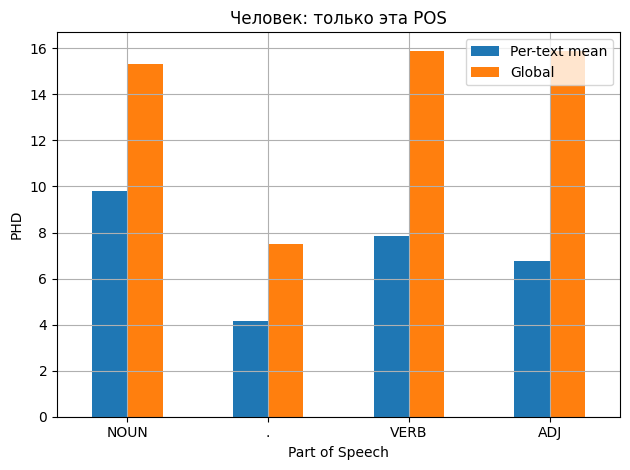

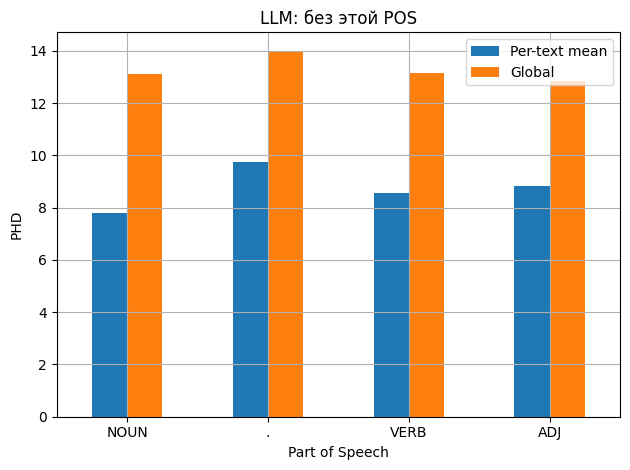

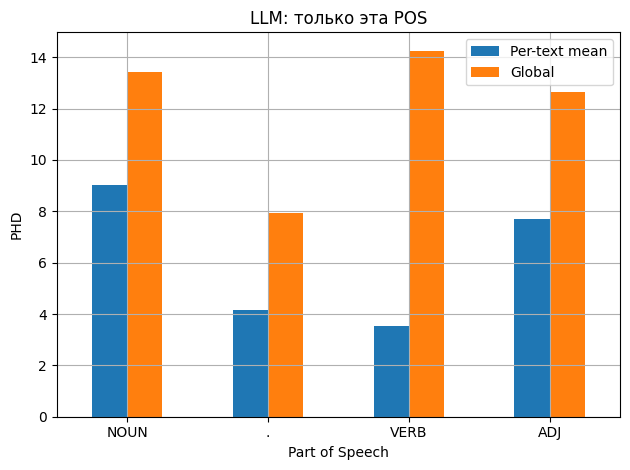

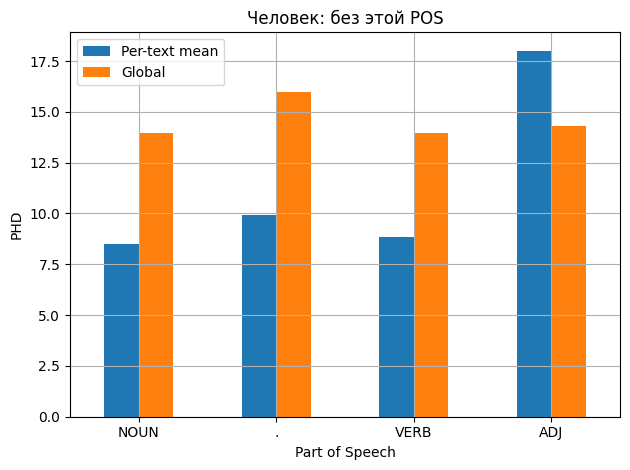

In [ ]:
plot_phd_comparison(pos_tags, phd_human_pertext_mean, phd_human_global_pos, "Человек: только эта POS")
plot_phd_comparison(pos_tags, phd_llm_pertext_wo_mean, phd_llm_global_wo, "LLM: без этой POS")
plot_phd_comparison(pos_tags, phd_llm_pertext_mean, phd_llm_global_pos, "LLM: только эта POS")
plot_phd_comparison(pos_tags, phd_human_pertext_wo_mean, phd_human_global_wo, "Человек: без этой POS")

In [ ]:
print_phd_mle_counts(count_human, "Человек: per-text (только эта POS)")
print_phd_mle_counts(count_human_wo, "Человек: per-text (без этой POS)")
print_phd_mle_counts(count_human_global, "Человек: global (только эта POS)")
print_phd_mle_counts(count_human_global_wo, "Человек: global (без этой POS)")

print_phd_mle_counts(count_llm, "LLM: per-text (только эта POS)")
print_phd_mle_counts(count_llm_wo, "LLM: per-text (без этой POS)")
print_phd_mle_counts(count_llm_global, "LLM: global (только эта POS)")
print_phd_mle_counts(count_llm_global_wo, "LLM: global (без этой POS)")


=== Человек: per-text (только эта POS) ===


,PHD count,MLE count,Total
NOUN,19,5,24
.,2,20,22
VERB,4,17,21
ADJ,3,18,21



=== Человек: per-text (без этой POS) ===


,PHD count,MLE count,Total
.,20,4,24
VERB,19,5,24
ADJ,20,4,24
NOUN,17,6,23



=== Человек: global (только эта POS) ===


,PHD count,MLE count,Total
NOUN,1,0,1
.,1,0,1
VERB,1,0,1
ADJ,1,0,1



=== Человек: global (без этой POS) ===


,PHD count,MLE count,Total
NOUN,1,0,1
.,1,0,1
VERB,1,0,1
ADJ,1,0,1



=== LLM: per-text (только эта POS) ===


,PHD count,MLE count,Total
NOUN,18,6,24
.,3,19,22
ADJ,6,16,22
VERB,9,11,20



=== LLM: per-text (без этой POS) ===


,PHD count,MLE count,Total
NOUN,17,7,24
.,22,2,24
VERB,22,2,24
ADJ,22,2,24



=== LLM: global (только эта POS) ===


,PHD count,MLE count,Total
NOUN,1,0,1
.,1,0,1
VERB,1,0,1
ADJ,1,0,1



=== LLM: global (без этой POS) ===


,PHD count,MLE count,Total
NOUN,1,0,1
.,1,0,1
VERB,1,0,1
ADJ,1,0,1


In [51]:
def plot_phd_boxplots(pos2phd_all, title):
    """
    Строит boxplot для PHD по каждой POS.

    Аргументы:
    - pos2phd_all: словарь {pos_tag: [список PHD по текстам]}
    - title: заголовок графика
    """
    pos_tags = list(pos2phd_all.keys())
    data = [pos2phd_all[pos] for pos in pos_tags]

    data = [[x for x in lst if x >= 0 and x <= 100] for lst in data]

    plt.figure(figsize=(8, 5))
    plt.boxplot(data, labels=pos_tags, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title(title)
    plt.ylabel("PHD")
    plt.xlabel("Part of Speech")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

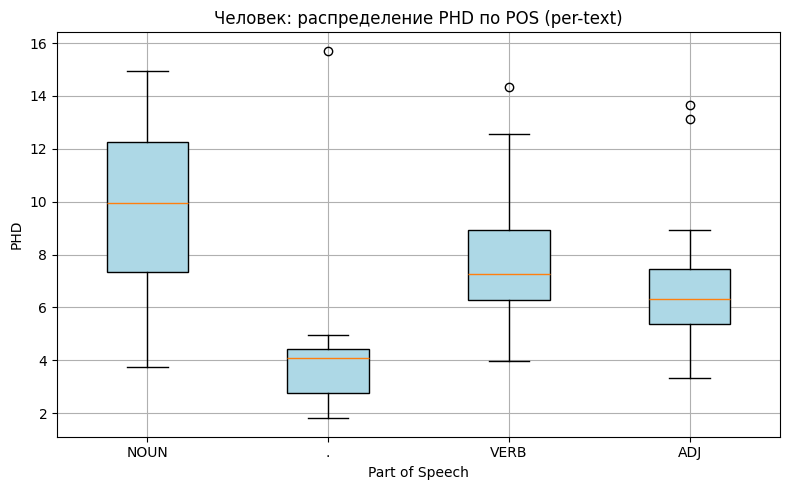

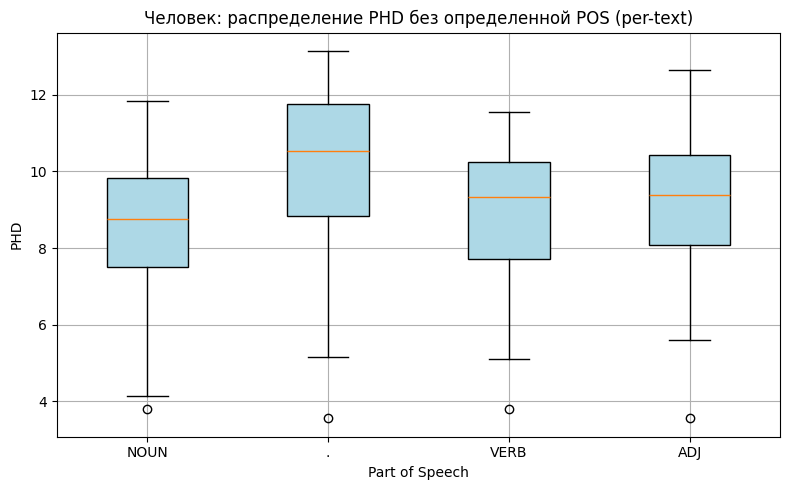

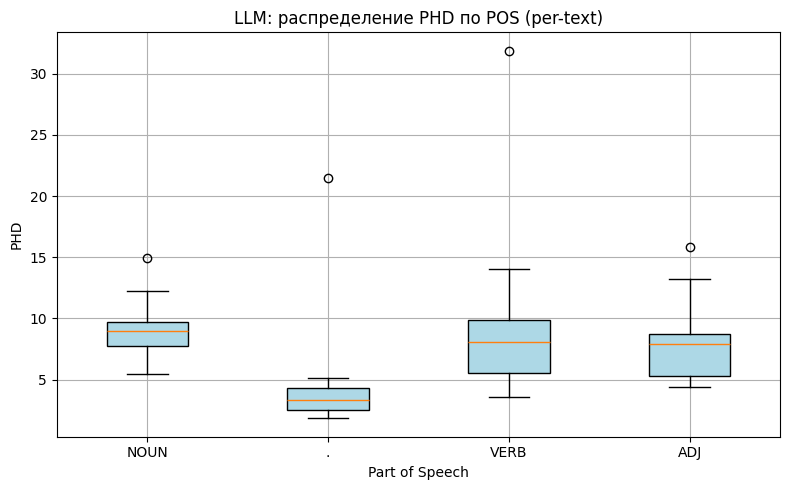

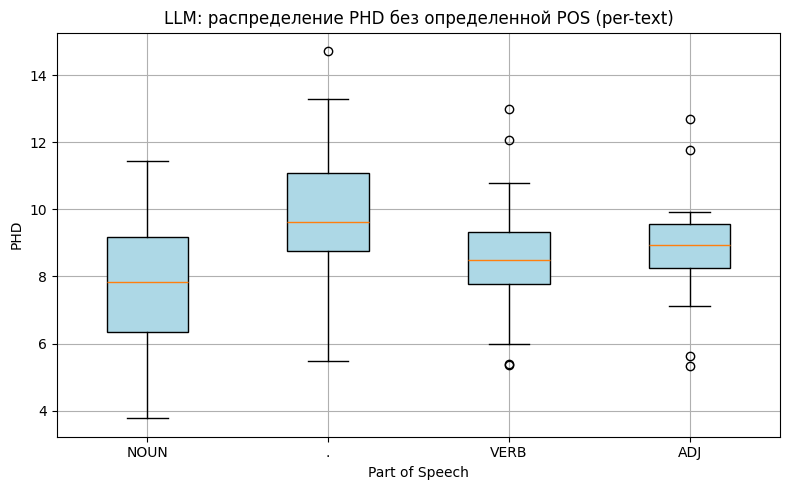

In [52]:
plot_phd_boxplots(phd_human_all, "Человек: распределение PHD по POS (per-text)")
plot_phd_boxplots(phd_human_all_wo, "Человек: распределение PHD без определенной POS (per-text)")
plot_phd_boxplots(phd_llm_all, "LLM: распределение PHD по POS (per-text)")
plot_phd_boxplots(phd_llm_all_wo, "LLM: распределение PHD без определенной POS (per-text)")

In [ ]:
print(df['text'].values[18])

An interesting episode of Dispatches ( A UK documentary program ) [ " Children Of The Secret State " ] ( URL_0 ) features footage from a North Korean citizen named Ahn Chol . This footage seems to be shot by a handheld video camera .


Посмотрим, что за тексты дают выбросы по phd

In [ ]:
phds = phd_llm_all["VERB"]

# Посмотрим на индексы с PHD > 30
outlier_indices = [i for i, v in enumerate(phds) if v < 5]
print(outlier_indices)

[2, 3, 10, 12, 18, 19]


In [ ]:
idx = outlier_indices[2]

# Получим текст, на котором считалось это значение
text = ''.join(df.query("label == 1")['text'].values.tolist()[2 + 2*idx : 2 + 2*idx + 1])
print(text)

Ajinkya Rahane became the fifth Indian to score centuries in both innings of a Test match as they declared on 267-5. In reply, captain Hashim Amla (23 not out) took South Africa close to their target with an unbeaten 32 but failed to complete his hundred by stumps. This was India's 10th five-wicket haul and second against West Indies after an eight-wicket one at Sabina Park three years ago for Ishant Sharma. It is also the sixth time this season that Rohit has scored more than 150 runs in four consecutive Tests. Ajinkya made 134 while Shikhar Dhawan (83), Cheteshwar Pujara (57) and Virat Kohli (43) all contributed during the first session which helped reduce Windies' lead from 249 to 251 early Monday morning at 1:00am BST. There were two rain delays during play before lunch - three hours between 8pm GMT on Sunday nightSunday morning local time until 2am BST when play resumed again followed by another delay till just after 9am BST due to heavy showers shortly afterwards causing the umpi

In [ ]:
phds = phd_human_all_wo["ADJ"]

outlier_indices = [i for i, v in enumerate(phds) if v >100]
print(outlier_indices)

[5]


In [ ]:
idx = outlier_indices[0]

# Получим текст, на котором считалось это значение
text = ''.join(df.query("label == 0")['text'].values.tolist()[2 + 2*idx : 2 + 2*idx + 1])
print(text)

Luke lived in a treehouse behind his families house. He climbed the branches like a monkey. One day, he was being careless and fell from the tree. He hit his head hard and woke up thinking he really was a monkey. Now Luke is called Chimples and only eats bananas.


In [53]:
def plot_phd_boxplots_compare_human_llm(phd_human_all, phd_llm_all, title, pos_tags):
    """
    Строит boxplot сравнения PHD между Human и LLM для каждой POS с разными цветами.

    Аргументы:
    - phd_human_all: словарь {pos_tag: [PHD-значения]} для человека
    - phd_llm_all: словарь {pos_tag: [PHD-значения]} для LLM
    - title: заголовок графика
    - pos_tags: список POS, которые рисовать
    """
    data = []
    colors = []
    labels = []

    for pos in pos_tags:
        # Фильтруем выбросы
        human_vals = [x for x in phd_human_all.get(pos, []) if 0 <= x <= 100]
        llm_vals = [x for x in phd_llm_all.get(pos, []) if 0 <= x <= 100]

        data.extend([human_vals, llm_vals])
        colors.extend(['lightblue', 'lightsalmon'])
        labels.extend([f"{pos}\nHuman", f"{pos}\nLLM"])

    plt.figure(figsize=(max(10, len(pos_tags)*1.5), 6))
    box = plt.boxplot(data, labels=labels, patch_artist=True)

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    plt.title(title)
    plt.ylabel("PHD")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

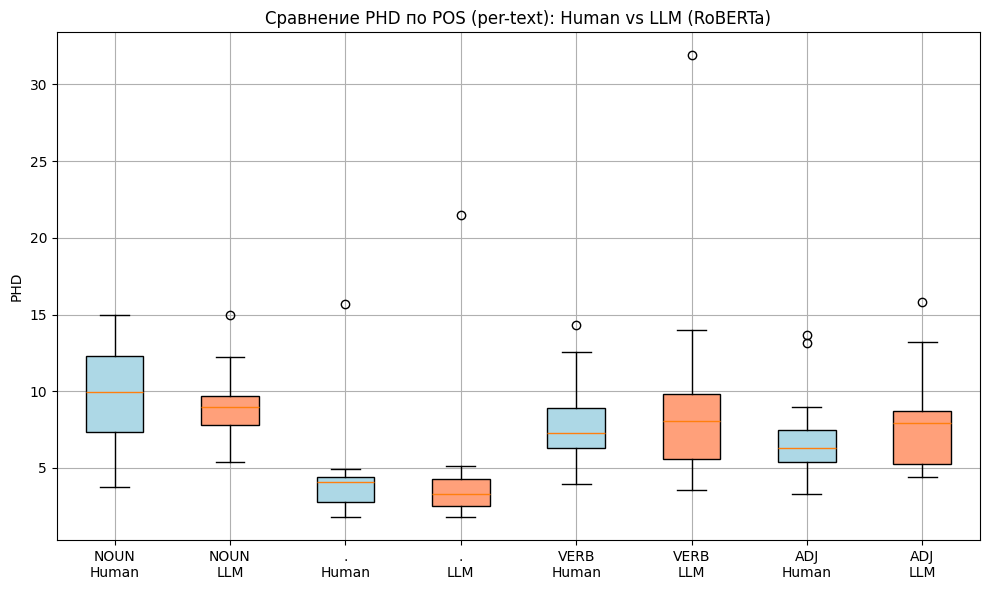

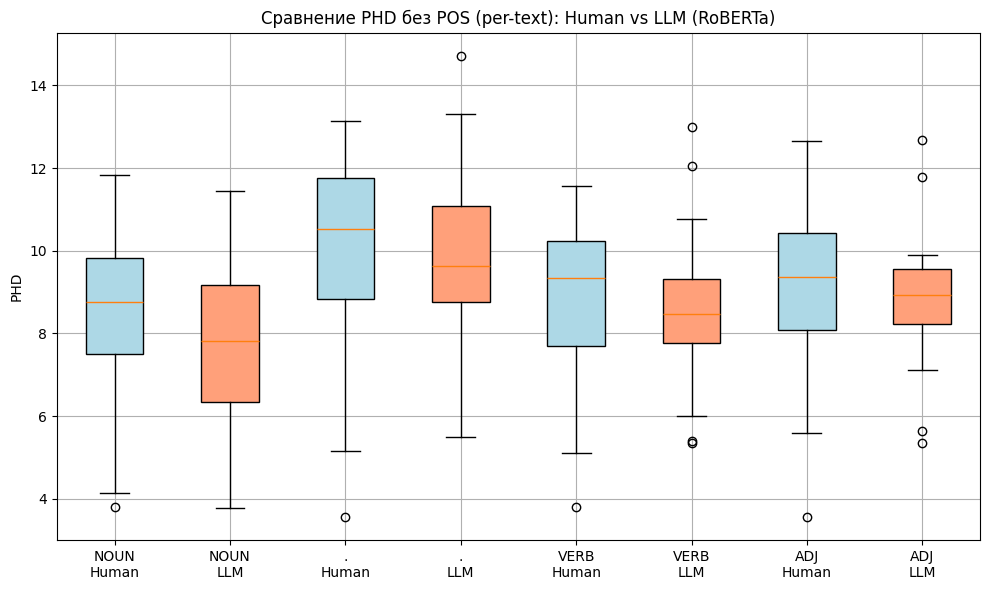

In [55]:
plot_phd_boxplots_compare_human_llm(
    phd_human_all, phd_llm_all,
    "Сравнение PHD по POS (per-text): Human vs LLM (RoBERTa)",
    pos_tags
)

plot_phd_boxplots_compare_human_llm(
    phd_human_all_wo, phd_llm_all_wo,
    "Сравнение PHD без POS (per-text): Human vs LLM (RoBERTa)",
    pos_tags
)


In [60]:
np.savez("/content/drive/MyDrive/Colab Notebooks/VZ_DS/PHD/TopAnDat/four_week/phd_results_RoBERT.npz",
    phd_llm_global_pos=phd_llm_global_pos,
    count_llm_global=count_llm_global,
    phd_llm_global_wo=phd_llm_global_wo,
    count_llm_global_wo=count_llm_global_wo,
    phd_llm_all=phd_llm_all,
    phd_llm_pertext_mean=phd_llm_pertext_mean,
    count_llm=count_llm,
    phd_llm_all_wo=phd_llm_all_wo,
    phd_llm_pertext_wo_mean=phd_llm_pertext_wo_mean,
    count_llm_wo=count_llm_wo,

    phd_human_global_pos=phd_human_global_pos,
    count_human_global=count_human_global,
    phd_human_global_wo=phd_human_global_wo,
    count_human_global_wo=count_human_global_wo,
    phd_human_all=phd_human_all,
    phd_human_pertext_mean=phd_human_pertext_mean,
    count_human=count_human,
    phd_human_all_wo=phd_human_all_wo,
    phd_human_pertext_wo_mean=phd_human_pertext_wo_mean,
    count_human_wo=count_human_wo
)